# Filter Analysis Notebook

This notebook analyzes the filtering process to understand:
1. What percentage of data is being filtered out
2. Which filters are removing the most data
3. Whether the filtering criteria are appropriate
4. Distribution of particle counts before and after filtering


In [1]:
# Import necessary libraries
import sys
from pathlib import Path
import os

from src.parse_atlas import parser
from src.calculations import physics_calcs
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import yaml
from collections import defaultdict
import pandas as pd

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Use default style
%matplotlib inline


In [2]:
# Load configuration
config_path = 'configs/pipeline_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
parsing_config = config['parsing_config']
particle_counts = parsing_config['particle_counts']
kinematic_cuts = parsing_config['kinematic_cuts']

print("Particle Count Filters:")
for particle, counts in particle_counts.items():
    print(f"  {particle}: {counts['min']} - {counts['max']}")

print("\nKinematic Cuts:")
for key, value in kinematic_cuts.items():
    print(f"  {key}: {value}")


Particle Count Filters:
  Electrons: 1 - 6
  Muons: 1 - 6
  Jets: 2 - 8
  Photons: 0 - 5

Kinematic Cuts:
  pt: {'min': 0}
  eta: {'min': -5, 'max': 5}
  phi: {'min': -3.141592653589793, 'max': 3.141592653589793}


## Load Sample Data

We'll load a small sample of data to analyze the filtering process.


In [3]:
# Initialize parser with a small subset for testing
atlasparser_config = config['parsing_config']['atlasparser_config']
pipeline_config = config['parsing_config']['pipeline_config']

# Create a test configuration with limited files
test_config = atlasparser_config.copy()
test_config['release_years'] = atlasparser_config['release_years'][:1]  # Just use first year

atlasparser = parser.AtlasOpenParser(**test_config)
files = atlasparser.fetch_record_ids()
parser.AtlasOpenParser.limit_files_per_year(files, 500)
# Get a small chunk of data
print("Loading sample data...")
events_chunk = None
for chunk in atlasparser.parse_files(files):
    events_chunk = chunk
    print(f"Loaded chunk with {len(chunk):,} events")
    print(f"Chunk size: {chunk.layout.nbytes / (1024**2):.2f} MB")
    break  # Just get first chunk

if events_chunk is None:
    print("ERROR: No data loaded!")
else:
    print(f"\nAvailable particle types: {events_chunk.fields}")


Fetching and caching all metadata for release: 2024r-pp...
Successfully cached 374 datasets.
Active release: 2024r-pp. (Datasets path: REMOTE)
Loading sample data...


Parsing files:   0%| | 1/500 [00:09<1:15:03,  9.03s/file,

✅ File processed: 0.95 MB logical size, 8,000 events.


Parsing files:   1%| | 3/500 [00:10<36:05,  4.36s/file,  

✅ File processed: 2.75 MB logical size, 20,000 events.
✅ File processed: 1.59 MB logical size, 10,000 events.
⚠️  High memory growth: 6.2 MB for 1.6 MB file
✅ File processed: 1.57 MB logical size, 10,000 events.


Parsing files:   1%| | 4/500 [00:10<36:01,  4.36s/file, 

✅ File processed: 2.34 MB logical size, 20,000 events.


Parsing files:   1%| | 6/500 [00:16<18:32,  2.25s/file, 

✅ File processed: 2.84 MB logical size, 20,000 events.
✅ File processed: 5.46 MB logical size, 30,000 events.


Parsing files:   2%| | 8/500 [00:20<17:56,  2.19s/file, 

✅ File processed: 6.23 MB logical size, 50,000 events.
✅ File processed: 6.23 MB logical size, 50,000 events.


Parsing files:   2%| | 10/500 [00:26<19:25,  2.38s/file, 

✅ File processed: 12.46 MB logical size, 100,000 events.


Parsing files:   2%| | 10/500 [00:26<19:25,  2.38s/file, 

✅ File processed: 6.23 MB logical size, 50,000 events.
⚠️  High memory growth: 20.0 MB for 6.2 MB file


Parsing files:   2%| | 12/500 [00:37<27:28,  3.38s/file, 

✅ File processed: 12.22 MB logical size, 98,000 events.


Parsing files:   3%| | 13/500 [00:42<29:53,  3.68s/file, 

✅ File processed: 24.96 MB logical size, 200,000 events.
✅ File processed: 24.94 MB logical size, 200,000 events.


Parsing files:   3%| | 14/500 [00:42<29:49,  3.68s/file, 

✅ File processed: 24.95 MB logical size, 200,000 events.


Parsing files:   3%| | 16/500 [00:47<22:50,  2.83s/file, 

✅ File processed: 24.96 MB logical size, 200,000 events.
⚠️  High memory growth: 100.0 MB for 25.0 MB file


Parsing files:   3%| | 16/500 [00:48<22:50,  2.83s/file, 

✅ File processed: 24.93 MB logical size, 200,000 events.
⚠️  High memory growth: 82.0 MB for 24.9 MB file


Parsing files:   4%| | 18/500 [00:54<24:14,  3.02s/file, 

✅ File processed: 24.94 MB logical size, 200,000 events.
⚠️  High memory growth: 118.7 MB for 24.9 MB file


Parsing files:   4%| | 19/500 [01:00<28:55,  3.61s/file, 

✅ File processed: 19.20 MB logical size, 154,000 events.
⚠️  High memory growth: 96.4 MB for 19.2 MB file
✅ File processed: 24.91 MB logical size, 200,000 events.


Parsing files:   4%| | 20/500 [01:07<28:51,  3.61s/file, 

✅ File processed: 24.92 MB logical size, 200,000 events.


Parsing files:   4%| | 21/500 [01:08<28:37,  3.59s/file, 

✅ File processed: 24.97 MB logical size, 200,000 events.
⚠️  High memory growth: 123.9 MB for 25.0 MB file


Parsing files:   5%| | 23/500 [01:08<28:30,  3.59s/file, 

✅ File processed: 19.05 MB logical size, 150,000 events.
⚠️  High memory growth: 92.9 MB for 19.0 MB file
✅ File processed: 17.48 MB logical size, 140,000 events.


Parsing files:   5%| | 23/500 [01:08<28:30,  3.59s/file, 

⚠️  High memory growth: 138.9 MB for 17.5 MB file


Parsing files:   5%| | 24/500 [01:08<28:26,  3.59s/file, 

✅ File processed: 19.06 MB logical size, 150,000 events.


Parsing files:   5%| | 25/500 [01:09<16:03,  2.03s/file, 

⚠️  High memory growth: 160.7 MB for 19.1 MB file


Parsing files:   5%| | 25/500 [01:17<16:03,  2.03s/file, 

✅ File processed: 24.93 MB logical size, 200,000 events.


Parsing files:   5%| | 26/500 [01:17<23:03,  2.92s/file, 

⚠️  High memory growth: 180.4 MB for 24.9 MB file


Parsing files:   5%| | 27/500 [01:22<25:27,  3.23s/file, 

✅ File processed: 11.30 MB logical size, 84,000 events.
⚠️  High memory growth: 47.7 MB for 11.3 MB file


✅ File processed: 12.86 MB logical size, 100,000 events.


Parsing files:   6%| | 28/500 [01:22<25:24,  3.23s/file, 

⚠️  High memory growth: 183.6 MB for 12.9 MB file
✅ File processed: 13.03 MB logical size, 100,000 events.


Parsing files:   6%| | 29/500 [01:23<18:17,  2.33s/file, 

⚠️  High memory growth: 75.0 MB for 13.0 MB file


Parsing files:   6%| | 29/500 [01:27<18:17,  2.33s/file, 

✅ File processed: 24.36 MB logical size, 192,000 events.


Parsing files:   6%| | 30/500 [01:27<21:25,  2.73s/file, 

⚠️  High memory growth: 264.9 MB for 24.4 MB file


Parsing files:   6%| | 30/500 [01:35<21:25,  2.73s/file, 

✅ File processed: 29.15 MB logical size, 220,000 events.


Parsing files:   6%| | 31/500 [01:36<31:01,  3.97s/file, 

⚠️  High memory growth: 145.1 MB for 29.1 MB file


Parsing files:   6%| | 31/500 [01:40<31:01,  3.97s/file, 

✅ File processed: 22.06 MB logical size, 160,000 events.


Parsing files:   6%| | 32/500 [01:40<31:57,  4.10s/file, 

⚠️  High memory growth: 261.8 MB for 22.1 MB file
✅ File processed: 22.64 MB logical size, 166,000 events.


Parsing files:   6%| | 32/500 [01:40<31:57,  4.10s/file, 

⚠️  High memory growth: 189.4 MB for 22.6 MB file


Parsing files:   7%| | 33/500 [01:41<31:53,  4.10s/file, 

✅ File processed: 12.87 MB logical size, 100,000 events.


Parsing files:   7%| | 33/500 [01:42<31:53,  4.10s/file, 

⚠️  High memory growth: 313.6 MB for 12.9 MB file


Parsing files:   7%| | 34/500 [01:42<21:41,  2.79s/file, 

✅ File processed: 19.46 MB logical size, 140,000 events.


Parsing files:   7%| | 34/500 [01:45<21:41,  2.79s/file, 

⚠️  High memory growth: 249.5 MB for 19.5 MB file


Parsing files:   7%| | 35/500 [01:47<22:02,  2.84s/file, 

✅ File processed: 19.01 MB logical size, 150,000 events.


Parsing files:   7%| | 36/500 [01:48<22:00,  2.85s/file, 

⚠️  High memory growth: 209.4 MB for 19.0 MB file


Parsing files:   7%| | 36/500 [01:50<22:00,  2.85s/file, 

✅ File processed: 30.10 MB logical size, 217,000 events.


Parsing files:   7%| | 37/500 [01:51<22:19,  2.89s/file, 

⚠️  High memory growth: 369.1 MB for 30.1 MB file
✅ File processed: 13.94 MB logical size, 100,000 events.


Parsing files:   8%| | 38/500 [01:51<22:17,  2.89s/file, 

⚠️  High memory growth: 349.5 MB for 13.9 MB file
✅ File processed: 5.07 MB logical size, 30,000 events.


Parsing files:   8%| | 38/500 [01:51<22:17,  2.89s/file, 

⚠️  High memory growth: 434.7 MB for 5.1 MB file


Parsing files:   8%| | 39/500 [01:56<22:14,  2.89s/file, 

✅ File processed: 30.92 MB logical size, 222,000 events.


Parsing files:   8%| | 40/500 [01:56<17:49,  2.32s/file, 

⚠️  High memory growth: 560.8 MB for 30.9 MB file
✅ File processed: 9.29 MB logical size, 67,000 events.


Parsing files:   8%| | 40/500 [01:58<17:49,  2.32s/file, 

⚠️  High memory growth: 541.5 MB for 9.3 MB file


Parsing files:   8%| | 41/500 [01:58<16:58,  2.22s/file, 

✅ File processed: 6.98 MB logical size, 30,000 events.


Parsing files:   8%| | 42/500 [02:00<16:26,  2.15s/file, 

⚠️  High memory growth: 535.8 MB for 7.0 MB file


Parsing files:   8%| | 42/500 [02:01<16:26,  2.15s/file, 

✅ File processed: 6.55 MB logical size, 29,000 events.


Parsing files:   9%| | 43/500 [02:02<16:00,  2.10s/file, 

⚠️  High memory growth: 619.0 MB for 6.6 MB file
✅ File processed: 5.13 MB logical size, 30,000 events.


Parsing files:   9%| | 43/500 [02:03<16:00,  2.10s/file, 

⚠️  High memory growth: 490.7 MB for 5.1 MB file


Parsing files:   9%| | 44/500 [02:04<14:48,  1.95s/file, 

✅ File processed: 3.58 MB logical size, 30,000 events.


Parsing files:   9%| | 45/500 [02:06<15:43,  2.07s/file, 

⚠️  High memory growth: 564.9 MB for 3.6 MB file


Parsing files:   9%| | 45/500 [02:06<15:43,  2.07s/file, 

✅ File processed: 2.53 MB logical size, 20,000 events.


Parsing files:   9%| | 46/500 [02:07<13:38,  1.80s/file, 

⚠️  High memory growth: 561.0 MB for 2.5 MB file
✅ File processed: 5.06 MB logical size, 40,000 events.


Parsing files:   9%| | 46/500 [02:07<13:38,  1.80s/file, 

⚠️  High memory growth: 605.3 MB for 5.1 MB file


Parsing files:   9%| | 47/500 [02:11<13:37,  1.80s/file, 

✅ File processed: 5.06 MB logical size, 40,000 events.


Parsing files:  10%| | 48/500 [02:11<14:53,  1.98s/file, 

⚠️  High memory growth: 528.4 MB for 5.1 MB file


Parsing files:  10%| | 48/500 [02:12<14:53,  1.98s/file, 

✅ File processed: 23.63 MB logical size, 170,000 events.


Parsing files:  10%| | 49/500 [02:13<14:35,  1.94s/file, 

⚠️  High memory growth: 593.9 MB for 23.6 MB file


Parsing files:  10%| | 49/500 [02:17<14:35,  1.94s/file, 

✅ File processed: 22.22 MB logical size, 161,000 events.


Parsing files:  10%| | 50/500 [02:17<18:33,  2.48s/file, 

⚠️  High memory growth: 593.5 MB for 22.2 MB file


Parsing files:  10%| | 50/500 [02:18<18:33,  2.48s/file, 

✅ File processed: 7.74 MB logical size, 50,000 events.


Parsing files:  10%| | 51/500 [02:19<17:47,  2.38s/file, 

⚠️  High memory growth: 614.0 MB for 7.7 MB file


Parsing files:  10%| | 51/500 [02:21<17:47,  2.38s/file, 

✅ File processed: 7.74 MB logical size, 50,000 events.


Parsing files:  10%| | 52/500 [02:22<17:35,  2.36s/file, 

⚠️  High memory growth: 587.5 MB for 7.7 MB file
✅ File processed: 16.04 MB logical size, 100,000 events.


Parsing files:  10%| | 52/500 [02:22<17:35,  2.36s/file, 

⚠️  High memory growth: 627.7 MB for 16.0 MB file


Parsing files:  11%| | 53/500 [02:25<17:33,  2.36s/file, 

✅ File processed: 14.98 MB logical size, 120,000 events.


Parsing files:  11%| | 54/500 [02:25<15:58,  2.15s/file, 

⚠️  High memory growth: 640.3 MB for 15.0 MB file
✅ File processed: 7.72 MB logical size, 50,000 events.


Parsing files:  11%| | 54/500 [02:26<15:58,  2.15s/file, 

⚠️  High memory growth: 650.5 MB for 7.7 MB file


Parsing files:  11%| | 55/500 [02:26<15:56,  2.15s/file, 

✅ File processed: 6.20 MB logical size, 40,000 events.


Parsing files:  11%| | 56/500 [02:29<15:33,  2.10s/file, 

⚠️  High memory growth: 659.7 MB for 6.2 MB file


Parsing files:  11%| | 56/500 [02:30<15:33,  2.10s/file, 

✅ File processed: 6.19 MB logical size, 40,000 events.


Parsing files:  11%| | 57/500 [02:31<15:01,  2.03s/file, 

⚠️  High memory growth: 623.5 MB for 6.2 MB file


Parsing files:  11%| | 57/500 [02:32<15:01,  2.03s/file, 

✅ File processed: 13.78 MB logical size, 105,000 events.


Parsing files:  12%| | 58/500 [02:33<14:20,  1.95s/file, 

⚠️  High memory growth: 712.1 MB for 13.8 MB file


Parsing files:  12%| | 58/500 [02:33<14:20,  1.95s/file, 

✅ File processed: 6.19 MB logical size, 40,000 events.


Parsing files:  12%| | 59/500 [02:34<14:18,  1.95s/file, 

⚠️  High memory growth: 591.1 MB for 6.2 MB file
✅ File processed: 6.18 MB logical size, 40,000 events.


Parsing files:  12%| | 59/500 [02:35<14:18,  1.95s/file, 

⚠️  High memory growth: 716.5 MB for 6.2 MB file


Parsing files:  12%| | 60/500 [02:37<11:57,  1.63s/file, 

✅ File processed: 6.19 MB logical size, 40,000 events.


Parsing files:  12%| | 61/500 [02:39<16:16,  2.22s/file, 

⚠️  High memory growth: 725.1 MB for 6.2 MB file


Parsing files:  12%| | 61/500 [02:42<16:16,  2.22s/file, 

✅ File processed: 26.95 MB logical size, 200,000 events.


Parsing files:  12%| | 62/500 [02:43<17:58,  2.46s/file, 

⚠️  High memory growth: 699.1 MB for 26.9 MB file


Parsing files:  12%| | 62/500 [02:48<17:58,  2.46s/file, 

✅ File processed: 23.21 MB logical size, 150,000 events.


Parsing files:  13%|▏| 63/500 [02:49<24:34,  3.37s/file, 

⚠️  High memory growth: 683.4 MB for 23.2 MB file


Parsing files:  13%|▏| 63/500 [02:49<24:34,  3.37s/file, 

✅ File processed: 23.22 MB logical size, 150,000 events.


Parsing files:  13%|▏| 63/500 [02:49<24:34,  3.37s/file, 

⚠️  High memory growth: 781.7 MB for 23.2 MB file


Parsing files:  13%|▏| 64/500 [02:50<24:31,  3.37s/file, 

✅ File processed: 26.31 MB logical size, 170,000 events.


Parsing files:  13%|▏| 64/500 [02:52<24:31,  3.37s/file, 

⚠️  High memory growth: 718.9 MB for 26.3 MB file


Parsing files:  13%|▏| 65/500 [02:55<19:13,  2.65s/file, 

✅ File processed: 21.65 MB logical size, 140,000 events.


Parsing files:  13%|▏| 66/500 [02:56<21:03,  2.91s/file, 

⚠️  High memory growth: 901.2 MB for 21.7 MB file
✅ File processed: 6.20 MB logical size, 40,000 events.


Parsing files:  13%|▏| 67/500 [02:56<21:00,  2.91s/file, 

⚠️  High memory growth: 765.0 MB for 6.2 MB file
✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  14%|▏| 68/500 [02:58<15:49,  2.20s/file, 

⚠️  High memory growth: 862.5 MB for 6.5 MB file


Parsing files:  14%|▏| 68/500 [03:03<15:49,  2.20s/file, 

✅ File processed: 24.47 MB logical size, 158,000 events.


Parsing files:  14%|▏| 69/500 [03:03<20:45,  2.89s/file, 

⚠️  High memory growth: 861.0 MB for 24.5 MB file
✅ File processed: 18.58 MB logical size, 120,000 events.


Parsing files:  14%|▏| 70/500 [03:04<20:42,  2.89s/file, 

⚠️  High memory growth: 857.1 MB for 18.6 MB file
✅ File processed: 24.77 MB logical size, 160,000 events.


Parsing files:  14%|▏| 70/500 [03:07<20:42,  2.89s/file, 

⚠️  High memory growth: 880.3 MB for 24.8 MB file


Parsing files:  14%|▏| 71/500 [03:08<17:57,  2.51s/file, 

✅ File processed: 7.03 MB logical size, 40,000 events.


Parsing files:  14%|▏| 72/500 [03:09<17:33,  2.46s/file, 

⚠️  High memory growth: 788.1 MB for 7.0 MB file


Parsing files:  14%|▏| 72/500 [03:10<17:33,  2.46s/file, 

✅ File processed: 6.76 MB logical size, 50,000 events.


Parsing files:  15%|▏| 73/500 [03:10<15:04,  2.12s/file, 

⚠️  High memory growth: 974.6 MB for 6.8 MB file


Parsing files:  15%|▏| 73/500 [03:11<15:04,  2.12s/file, 

✅ File processed: 5.77 MB logical size, 39,000 events.


Parsing files:  15%|▏| 74/500 [03:11<15:02,  2.12s/file, 

⚠️  High memory growth: 817.1 MB for 5.8 MB file
✅ File processed: 24.79 MB logical size, 160,000 events.


Parsing files:  15%|▏| 75/500 [03:12<11:53,  1.68s/file, 

⚠️  High memory growth: 1005.4 MB for 24.8 MB file


Parsing files:  15%|▏| 75/500 [03:13<11:53,  1.68s/file, 

✅ File processed: 4.07 MB logical size, 30,000 events.


Parsing files:  15%|▏| 75/500 [03:15<11:53,  1.68s/file, 

⚠️  High memory growth: 908.9 MB for 4.1 MB file


Parsing files:  15%|▏| 76/500 [03:18<14:43,  2.08s/file, 

✅ File processed: 6.73 MB logical size, 50,000 events.


Parsing files:  15%|▏| 77/500 [03:18<15:18,  2.17s/file, 

⚠️  High memory growth: 913.8 MB for 6.7 MB file


Parsing files:  15%|▏| 77/500 [03:20<15:18,  2.17s/file, 

✅ File processed: 17.88 MB logical size, 150,000 events.


Parsing files:  16%|▏| 78/500 [03:21<16:18,  2.32s/file, 

⚠️  High memory growth: 1022.0 MB for 17.9 MB file
✅ File processed: 14.64 MB logical size, 120,000 events.


Parsing files:  16%|▏| 78/500 [03:22<16:18,  2.32s/file, 

⚠️  High memory growth: 940.4 MB for 14.6 MB file


Parsing files:  16%|▏| 79/500 [03:29<16:16,  2.32s/file, 

✅ File processed: 15.67 MB logical size, 120,000 events.


Parsing files:  16%|▏| 80/500 [03:29<21:28,  3.07s/file, 

⚠️  High memory growth: 1048.6 MB for 15.7 MB file
✅ File processed: 6.49 MB logical size, 50,000 events.


Parsing files:  16%|▏| 81/500 [03:30<21:25,  3.07s/file, 

⚠️  High memory growth: 1062.4 MB for 6.5 MB file
✅ File processed: 6.50 MB logical size, 50,000 events.


Parsing files:  16%|▏| 82/500 [03:32<17:18,  2.48s/file, 

⚠️  High memory growth: 963.3 MB for 6.5 MB file


Parsing files:  16%|▏| 82/500 [03:37<17:18,  2.48s/file, 

✅ File processed: 5.20 MB logical size, 40,000 events.


Parsing files:  17%|▏| 83/500 [03:38<21:17,  3.06s/file, 

⚠️  High memory growth: 1086.3 MB for 5.2 MB file
✅ File processed: 21.81 MB logical size, 168,000 events.


Parsing files:  17%|▏| 84/500 [03:38<21:14,  3.06s/file, 

⚠️  High memory growth: 1082.9 MB for 21.8 MB file
✅ File processed: 17.48 MB logical size, 140,000 events.


Parsing files:  17%|▏| 84/500 [03:41<21:14,  3.06s/file, 

⚠️  High memory growth: 1052.0 MB for 17.5 MB file


Parsing files:  17%|▏| 85/500 [03:43<18:34,  2.69s/file, 

✅ File processed: 6.51 MB logical size, 50,000 events.


Parsing files:  17%|▏| 86/500 [03:45<19:23,  2.81s/file, 

⚠️  High memory growth: 1104.5 MB for 6.5 MB file
✅ File processed: 6.52 MB logical size, 50,000 events.


Parsing files:  17%|▏| 87/500 [03:46<19:21,  2.81s/file, 

⚠️  High memory growth: 1125.5 MB for 6.5 MB file
✅ File processed: 12.84 MB logical size, 100,000 events.


Parsing files:  18%|▏| 88/500 [03:47<13:57,  2.03s/file, 

⚠️  High memory growth: 1021.5 MB for 12.8 MB file
✅ File processed: 5.20 MB logical size, 40,000 events.


Parsing files:  18%|▏| 89/500 [03:48<12:42,  1.85s/file, 

⚠️  High memory growth: 1145.2 MB for 5.2 MB file


Parsing files:  18%|▏| 89/500 [03:48<12:42,  1.85s/file, 

✅ File processed: 5.22 MB logical size, 40,000 events.


Parsing files:  18%|▏| 90/500 [03:50<13:37,  1.99s/file, 

⚠️  High memory growth: 1030.2 MB for 5.2 MB file


Parsing files:  18%|▏| 90/500 [03:51<13:37,  1.99s/file, 

✅ File processed: 24.97 MB logical size, 200,000 events.


Parsing files:  18%|▏| 91/500 [03:53<15:35,  2.29s/file, 

⚠️  High memory growth: 1162.9 MB for 25.0 MB file


Parsing files:  18%|▏| 91/500 [03:57<15:35,  2.29s/file, 

✅ File processed: 5.19 MB logical size, 40,000 events.


Parsing files:  18%|▏| 92/500 [03:58<19:06,  2.81s/file, 

⚠️  High memory growth: 1159.1 MB for 5.2 MB file


Parsing files:  18%|▏| 92/500 [03:59<19:06,  2.81s/file, 

✅ File processed: 19.49 MB logical size, 150,000 events.


Parsing files:  19%|▏| 93/500 [04:01<19:27,  2.87s/file, 

⚠️  High memory growth: 1054.0 MB for 19.5 MB file


Parsing files:  19%|▏| 93/500 [04:03<19:27,  2.87s/file, 

✅ File processed: 15.60 MB logical size, 120,000 events.


Parsing files:  19%|▏| 94/500 [04:04<19:34,  2.89s/file, 

⚠️  High memory growth: 1190.4 MB for 15.6 MB file
✅ File processed: 6.52 MB logical size, 50,000 events.


Parsing files:  19%|▏| 95/500 [04:05<17:28,  2.59s/file, 

⚠️  High memory growth: 1090.1 MB for 6.5 MB file


Parsing files:  19%|▏| 95/500 [04:06<17:28,  2.59s/file, 

✅ File processed: 5.19 MB logical size, 40,000 events.


Parsing files:  19%|▏| 96/500 [04:07<15:53,  2.36s/file, 

⚠️  High memory growth: 1200.9 MB for 5.2 MB file
✅ File processed: 18.20 MB logical size, 140,000 events.


Parsing files:  19%|▏| 96/500 [04:08<15:53,  2.36s/file, 

⚠️  High memory growth: 1217.1 MB for 18.2 MB file


Parsing files:  19%|▏| 97/500 [04:11<15:50,  2.36s/file, 

✅ File processed: 4.85 MB logical size, 40,000 events.


Parsing files:  20%|▏| 98/500 [04:12<15:43,  2.35s/file, 

⚠️  High memory growth: 1113.5 MB for 4.9 MB file
✅ File processed: 4.87 MB logical size, 40,000 events.


Parsing files:  20%|▏| 99/500 [04:13<14:17,  2.14s/file, 

⚠️  High memory growth: 1237.3 MB for 4.9 MB file


Parsing files:  20%|▏| 99/500 [04:16<14:17,  2.14s/file, 

✅ File processed: 4.84 MB logical size, 40,000 events.


Parsing files:  20%|▏| 100/500 [04:17<17:41,  2.65s/file,

⚠️  High memory growth: 1189.9 MB for 4.8 MB file


Parsing files:  20%|▏| 100/500 [04:18<17:41,  2.65s/file,

✅ File processed: 4.87 MB logical size, 40,000 events.


Parsing files:  20%|▏| 100/500 [04:21<17:41,  2.65s/file,

⚠️  High memory growth: 1307.2 MB for 4.9 MB file


Parsing files:  20%|▏| 101/500 [04:22<19:13,  2.89s/file,

✅ File processed: 15.61 MB logical size, 120,000 events.


Parsing files:  20%|▏| 102/500 [04:24<19:57,  3.01s/file,

⚠️  High memory growth: 1248.1 MB for 15.6 MB file
✅ File processed: 15.37 MB logical size, 118,000 events.


Parsing files:  21%|▏| 103/500 [04:25<19:54,  3.01s/file,

⚠️  High memory growth: 1261.7 MB for 15.4 MB file
✅ File processed: 33.28 MB logical size, 280,000 events.


Parsing files:  21%|▏| 104/500 [04:26<13:39,  2.07s/file,

⚠️  High memory growth: 1315.4 MB for 33.3 MB file
✅ File processed: 15.63 MB logical size, 120,000 events.


Parsing files:  21%|▏| 105/500 [04:28<12:40,  1.92s/file,

⚠️  High memory growth: 1308.4 MB for 15.6 MB file


Parsing files:  21%|▏| 105/500 [04:28<12:40,  1.92s/file,

✅ File processed: 4.86 MB logical size, 40,000 events.


Parsing files:  21%|▏| 106/500 [04:30<12:51,  1.96s/file,

⚠️  High memory growth: 1312.6 MB for 4.9 MB file


Parsing files:  21%|▏| 106/500 [04:33<12:51,  1.96s/file,

✅ File processed: 8.52 MB logical size, 70,000 events.


Parsing files:  21%|▏| 107/500 [04:34<17:12,  2.63s/file,

⚠️  High memory growth: 1320.2 MB for 8.5 MB file


Parsing files:  21%|▏| 107/500 [04:38<17:12,  2.63s/file,

✅ File processed: 5.36 MB logical size, 40,000 events.


Parsing files:  22%|▏| 108/500 [04:38<20:19,  3.11s/file,

⚠️  High memory growth: 1325.1 MB for 5.4 MB file


Parsing files:  22%|▏| 108/500 [04:39<20:19,  3.11s/file,

✅ File processed: 17.05 MB logical size, 140,000 events.


Parsing files:  22%|▏| 109/500 [04:40<16:57,  2.60s/file,

⚠️  High memory growth: 1348.1 MB for 17.0 MB file
✅ File processed: 19.48 MB logical size, 160,000 events.


Parsing files:  22%|▏| 109/500 [04:42<16:57,  2.60s/file,

⚠️  High memory growth: 1366.4 MB for 19.5 MB file


Parsing files:  22%|▏| 110/500 [04:43<16:44,  2.58s/file,

✅ File processed: 19.47 MB logical size, 160,000 events.


Parsing files:  22%|▏| 111/500 [04:45<16:24,  2.53s/file,

⚠️  High memory growth: 1374.8 MB for 19.5 MB file
✅ File processed: 15.57 MB logical size, 128,000 events.


Parsing files:  22%|▏| 112/500 [04:46<13:58,  2.16s/file,

⚠️  High memory growth: 1394.2 MB for 15.6 MB file


Parsing files:  22%|▏| 112/500 [04:48<13:58,  2.16s/file,

✅ File processed: 5.71 MB logical size, 40,000 events.


Parsing files:  23%|▏| 113/500 [04:49<16:21,  2.54s/file,

⚠️  High memory growth: 1398.2 MB for 5.7 MB file
✅ File processed: 5.70 MB logical size, 40,000 events.


Parsing files:  23%|▏| 113/500 [04:51<16:21,  2.54s/file,

⚠️  High memory growth: 1412.0 MB for 5.7 MB file


Parsing files:  23%|▏| 114/500 [04:53<15:50,  2.46s/file,

✅ File processed: 6.71 MB logical size, 50,000 events.


Parsing files:  23%|▏| 115/500 [04:56<18:49,  2.94s/file,

⚠️  High memory growth: 1403.8 MB for 6.7 MB file
✅ File processed: 6.42 MB logical size, 45,000 events.


Parsing files:  23%|▏| 116/500 [04:57<15:07,  2.36s/file,

⚠️  High memory growth: 1409.5 MB for 6.4 MB file
✅ File processed: 6.76 MB logical size, 50,000 events.


Parsing files:  23%|▏| 117/500 [04:58<12:31,  1.96s/file,

⚠️  High memory growth: 1417.8 MB for 6.8 MB file
✅ File processed: 19.48 MB logical size, 160,000 events.


Parsing files:  24%|▏| 118/500 [04:59<10:44,  1.69s/file,

⚠️  High memory growth: 1441.4 MB for 19.5 MB file
✅ File processed: 19.50 MB logical size, 160,000 events.


Parsing files:  24%|▏| 118/500 [05:03<10:44,  1.69s/file,

⚠️  High memory growth: 1439.1 MB for 19.5 MB file


Parsing files:  24%|▏| 119/500 [05:04<15:32,  2.45s/file,

✅ File processed: 19.43 MB logical size, 160,000 events.


Parsing files:  24%|▏| 120/500 [05:06<17:14,  2.72s/file,

⚠️  High memory growth: 1466.3 MB for 19.4 MB file
✅ File processed: 5.72 MB logical size, 40,000 events.


Parsing files:  24%|▏| 121/500 [05:08<14:04,  2.23s/file,

⚠️  High memory growth: 1475.2 MB for 5.7 MB file
✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  24%|▏| 121/500 [05:10<14:04,  2.23s/file,

⚠️  High memory growth: 1471.1 MB for 6.7 MB file


Parsing files:  24%|▏| 122/500 [05:11<15:58,  2.53s/file,

✅ File processed: 5.93 MB logical size, 44,000 events.


Parsing files:  25%|▏| 123/500 [05:13<15:45,  2.51s/file,

⚠️  High memory growth: 1482.5 MB for 5.9 MB file
✅ File processed: 2.70 MB logical size, 20,000 events.


Parsing files:  25%|▏| 124/500 [05:14<13:01,  2.08s/file,

⚠️  High memory growth: 1484.9 MB for 2.7 MB file
✅ File processed: 9.95 MB logical size, 74,000 events.


Parsing files:  25%|▏| 124/500 [05:16<13:01,  2.08s/file,

⚠️  High memory growth: 1494.1 MB for 9.9 MB file


Parsing files:  25%|▎| 125/500 [05:18<13:24,  2.14s/file,

✅ File processed: 5.67 MB logical size, 40,000 events.


Parsing files:  25%|▎| 126/500 [05:21<17:30,  2.81s/file,

⚠️  High memory growth: 1523.6 MB for 5.7 MB file


Parsing files:  25%|▎| 126/500 [05:21<17:30,  2.81s/file,

✅ File processed: 5.71 MB logical size, 40,000 events.


Parsing files:  25%|▎| 127/500 [05:23<15:59,  2.57s/file,

⚠️  High memory growth: 1504.2 MB for 5.7 MB file
✅ File processed: 2.84 MB logical size, 20,000 events.


Parsing files:  26%|▎| 128/500 [05:24<13:40,  2.21s/file,

⚠️  High memory growth: 1516.9 MB for 2.8 MB file
✅ File processed: 2.84 MB logical size, 20,000 events.


Parsing files:  26%|▎| 129/500 [05:27<13:48,  2.23s/file,

⚠️  High memory growth: 1509.2 MB for 2.8 MB file
✅ File processed: 2.85 MB logical size, 20,000 events.


Parsing files:  26%|▎| 130/500 [05:29<13:28,  2.19s/file,

⚠️  High memory growth: 1511.8 MB for 2.8 MB file
✅ File processed: 2.84 MB logical size, 20,000 events.


Parsing files:  26%|▎| 131/500 [05:30<11:54,  1.94s/file,

⚠️  High memory growth: 1516.8 MB for 2.8 MB file
✅ File processed: 2.83 MB logical size, 20,000 events.


Parsing files:  26%|▎| 132/500 [05:31<10:21,  1.69s/file,

⚠️  High memory growth: 1516.8 MB for 2.8 MB file
✅ File processed: 5.67 MB logical size, 40,000 events.


Parsing files:  27%|▎| 133/500 [05:33<10:54,  1.78s/file,

⚠️  High memory growth: 1521.8 MB for 5.7 MB file
✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  27%|▎| 134/500 [05:35<10:36,  1.74s/file,

⚠️  High memory growth: 1545.9 MB for 6.7 MB file
✅ File processed: 2.83 MB logical size, 20,000 events.


Parsing files:  27%|▎| 135/500 [05:36<09:21,  1.54s/file,

⚠️  High memory growth: 1530.2 MB for 2.8 MB file
✅ File processed: 5.67 MB logical size, 40,000 events.


Parsing files:  27%|▎| 136/500 [05:37<09:20,  1.54s/file,

⚠️  High memory growth: 1535.2 MB for 5.7 MB file
✅ File processed: 5.67 MB logical size, 40,000 events.


⚠️  High memory growth: 1540.0 MB for 5.7 MB file


Parsing files:  27%|▎| 137/500 [05:39<09:03,  1.50s/file,

✅ File processed: 3.14 MB logical size, 20,000 events.


Parsing files:  28%|▎| 138/500 [05:40<08:44,  1.45s/file,

⚠️  High memory growth: 1558.8 MB for 3.1 MB file
✅ File processed: 3.13 MB logical size, 20,000 events.


Parsing files:  28%|▎| 139/500 [05:42<09:18,  1.55s/file,

⚠️  High memory growth: 1563.7 MB for 3.1 MB file
✅ File processed: 14.21 MB logical size, 100,000 events.


Parsing files:  28%|▎| 140/500 [05:44<09:32,  1.59s/file,

⚠️  High memory growth: 1574.5 MB for 14.2 MB file


Parsing files:  28%|▎| 140/500 [05:44<09:32,  1.59s/file,

✅ File processed: 17.03 MB logical size, 120,000 events.


Parsing files:  28%|▎| 141/500 [05:46<10:53,  1.82s/file,

⚠️  High memory growth: 1573.3 MB for 17.0 MB file
✅ File processed: 6.28 MB logical size, 40,000 events.


Parsing files:  28%|▎| 142/500 [05:47<09:36,  1.61s/file,

⚠️  High memory growth: 1593.8 MB for 6.3 MB file
✅ File processed: 11.96 MB logical size, 80,000 events.


Parsing files:  29%|▎| 143/500 [05:49<10:18,  1.73s/file,

⚠️  High memory growth: 1645.8 MB for 12.0 MB file
✅ File processed: 14.20 MB logical size, 100,000 events.


Parsing files:  29%|▎| 144/500 [05:50<09:20,  1.57s/file,

⚠️  High memory growth: 1606.1 MB for 14.2 MB file
✅ File processed: 6.04 MB logical size, 50,000 events.


Parsing files:  29%|▎| 145/500 [05:52<09:09,  1.55s/file,

⚠️  High memory growth: 1616.8 MB for 6.0 MB file


Parsing files:  29%|▎| 145/500 [05:53<09:09,  1.55s/file,

✅ File processed: 4.85 MB logical size, 40,000 events.


Parsing files:  29%|▎| 146/500 [05:55<11:20,  1.92s/file,

⚠️  High memory growth: 1612.7 MB for 4.9 MB file


Parsing files:  29%|▎| 146/500 [05:56<11:20,  1.92s/file,

✅ File processed: 16.48 MB logical size, 120,000 events.


⚠️  High memory growth: 1652.8 MB for 16.5 MB file


Parsing files:  29%|▎| 147/500 [05:58<12:16,  2.09s/file,

✅ File processed: 21.13 MB logical size, 167,000 events.


Parsing files:  30%|▎| 148/500 [05:59<12:09,  2.07s/file,

⚠️  High memory growth: 1645.0 MB for 21.1 MB file
✅ File processed: 5.17 MB logical size, 40,000 events.


⚠️  High memory growth: 1654.8 MB for 5.2 MB file


Parsing files:  30%|▎| 149/500 [06:01<11:13,  1.92s/file,

✅ File processed: 5.19 MB logical size, 40,000 events.


Parsing files:  30%|▎| 150/500 [06:03<12:06,  2.08s/file,

⚠️  High memory growth: 1654.3 MB for 5.2 MB file


Parsing files:  30%|▎| 150/500 [06:05<12:06,  2.08s/file,

✅ File processed: 5.18 MB logical size, 40,000 events.


Parsing files:  30%|▎| 151/500 [06:08<16:20,  2.81s/file,

⚠️  High memory growth: 1670.9 MB for 5.2 MB file


Parsing files:  30%|▎| 151/500 [06:09<16:20,  2.81s/file,

✅ File processed: 17.90 MB logical size, 120,000 events.


Parsing files:  30%|▎| 152/500 [06:10<15:54,  2.74s/file,

⚠️  High memory growth: 1688.1 MB for 17.9 MB file
✅ File processed: 5.18 MB logical size, 40,000 events.


Parsing files:  30%|▎| 152/500 [06:13<15:54,  2.74s/file,

⚠️  High memory growth: 1705.6 MB for 5.2 MB file


Parsing files:  31%|▎| 153/500 [06:13<15:47,  2.73s/file,

✅ File processed: 32.59 MB logical size, 218,000 events.


Parsing files:  31%|▎| 154/500 [06:15<14:57,  2.59s/file,

⚠️  High memory growth: 1712.2 MB for 32.6 MB file
✅ File processed: 5.17 MB logical size, 40,000 events.


Parsing files:  31%|▎| 155/500 [06:17<12:53,  2.24s/file,

⚠️  High memory growth: 1731.9 MB for 5.2 MB file
✅ File processed: 5.17 MB logical size, 40,000 events.


Parsing files:  31%|▎| 155/500 [06:20<12:53,  2.24s/file,

⚠️  High memory growth: 1727.3 MB for 5.2 MB file


Parsing files:  31%|▎| 156/500 [06:20<14:29,  2.53s/file,

✅ File processed: 13.69 MB logical size, 100,000 events.


Parsing files:  31%|▎| 157/500 [06:22<14:09,  2.48s/file,

⚠️  High memory growth: 1733.5 MB for 13.7 MB file
✅ File processed: 2.58 MB logical size, 20,000 events.


⚠️  High memory growth: 1744.8 MB for 2.6 MB file


Parsing files:  32%|▎| 158/500 [06:25<13:57,  2.45s/file,

✅ File processed: 5.16 MB logical size, 40,000 events.


Parsing files:  32%|▎| 159/500 [06:26<12:13,  2.15s/file,

⚠️  High memory growth: 1740.5 MB for 5.2 MB file
✅ File processed: 5.18 MB logical size, 40,000 events.


Parsing files:  32%|▎| 160/500 [06:27<10:49,  1.91s/file,

⚠️  High memory growth: 1745.2 MB for 5.2 MB file
✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  32%|▎| 160/500 [06:30<10:49,  1.91s/file,

⚠️  High memory growth: 1750.9 MB for 4.9 MB file


Parsing files:  32%|▎| 161/500 [06:31<12:39,  2.24s/file,

✅ File processed: 5.17 MB logical size, 40,000 events.


Parsing files:  32%|▎| 162/500 [06:33<13:13,  2.35s/file,

⚠️  High memory growth: 1754.6 MB for 5.2 MB file
✅ File processed: 4.95 MB logical size, 40,000 events.


Parsing files:  33%|▎| 163/500 [06:34<11:19,  2.02s/file,

⚠️  High memory growth: 1759.4 MB for 4.9 MB file
✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  33%|▎| 163/500 [06:37<11:19,  2.02s/file,

⚠️  High memory growth: 1777.0 MB for 4.9 MB file


Parsing files:  33%|▎| 164/500 [06:37<12:09,  2.17s/file,

✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  33%|▎| 165/500 [06:39<12:45,  2.29s/file,

⚠️  High memory growth: 1769.4 MB for 4.9 MB file
✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  33%|▎| 166/500 [06:41<11:02,  1.98s/file,

⚠️  High memory growth: 1774.2 MB for 4.9 MB file
✅ File processed: 4.96 MB logical size, 40,000 events.


Parsing files:  33%|▎| 167/500 [06:42<10:32,  1.90s/file,

⚠️  High memory growth: 1779.1 MB for 5.0 MB file


Parsing files:  33%|▎| 167/500 [06:42<10:32,  1.90s/file,

✅ File processed: 4.93 MB logical size, 40,000 events.


Parsing files:  34%|▎| 168/500 [06:44<10:28,  1.89s/file,

⚠️  High memory growth: 1821.0 MB for 4.9 MB file
✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  34%|▎| 168/500 [06:48<10:28,  1.89s/file,

⚠️  High memory growth: 1799.2 MB for 4.9 MB file


Parsing files:  34%|▎| 169/500 [06:48<13:23,  2.43s/file,

✅ File processed: 4.94 MB logical size, 40,000 events.


Parsing files:  34%|▎| 170/500 [06:51<13:50,  2.52s/file,

⚠️  High memory growth: 1793.7 MB for 4.9 MB file
✅ File processed: 7.65 MB logical size, 50,000 events.


Parsing files:  34%|▎| 170/500 [06:52<13:50,  2.52s/file,

⚠️  High memory growth: 1800.4 MB for 7.7 MB file


Parsing files:  34%|▎| 171/500 [06:53<13:55,  2.54s/file,

✅ File processed: 7.66 MB logical size, 50,000 events.


Parsing files:  34%|▎| 172/500 [06:56<14:37,  2.68s/file,

⚠️  High memory growth: 1826.9 MB for 7.7 MB file
✅ File processed: 7.66 MB logical size, 50,000 events.


Parsing files:  35%|▎| 173/500 [06:58<12:44,  2.34s/file,

⚠️  High memory growth: 1814.0 MB for 7.7 MB file
✅ File processed: 29.41 MB logical size, 219,000 events.


Parsing files:  35%|▎| 173/500 [07:00<12:44,  2.34s/file,

⚠️  High memory growth: 1869.4 MB for 29.4 MB file


Parsing files:  35%|▎| 174/500 [07:00<13:02,  2.40s/file,

✅ File processed: 4.95 MB logical size, 40,000 events.


Parsing files:  35%|▎| 175/500 [07:03<13:15,  2.45s/file,

⚠️  High memory growth: 1843.4 MB for 4.9 MB file


Parsing files:  35%|▎| 175/500 [07:03<13:15,  2.45s/file,

✅ File processed: 7.67 MB logical size, 50,000 events.


Parsing files:  35%|▎| 176/500 [07:05<13:32,  2.51s/file,

⚠️  High memory growth: 1850.2 MB for 7.7 MB file
✅ File processed: 1.52 MB logical size, 10,000 events.


Parsing files:  35%|▎| 177/500 [07:07<11:57,  2.22s/file,

⚠️  High memory growth: 1856.7 MB for 1.5 MB file
✅ File processed: 9.77 MB logical size, 79,000 events.


Parsing files:  36%|▎| 178/500 [07:09<12:00,  2.24s/file,

⚠️  High memory growth: 1861.4 MB for 9.8 MB file
✅ File processed: 6.07 MB logical size, 40,000 events.


⚠️  High memory growth: 1866.6 MB for 6.1 MB file


Parsing files:  36%|▎| 179/500 [07:11<11:42,  2.19s/file,

✅ File processed: 7.65 MB logical size, 50,000 events.


Parsing files:  36%|▎| 180/500 [07:13<10:50,  2.03s/file,

⚠️  High memory growth: 1905.8 MB for 7.7 MB file
✅ File processed: 1.52 MB logical size, 10,000 events.


Parsing files:  36%|▎| 181/500 [07:15<10:13,  1.92s/file,

⚠️  High memory growth: 1874.6 MB for 1.5 MB file


Parsing files:  36%|▎| 181/500 [07:15<10:13,  1.92s/file,

✅ File processed: 4.38 MB logical size, 29,000 events.


Parsing files:  36%|▎| 182/500 [07:17<11:11,  2.11s/file,

⚠️  High memory growth: 1878.3 MB for 4.4 MB file
✅ File processed: 5.96 MB logical size, 40,000 events.


Parsing files:  37%|▎| 183/500 [07:19<09:58,  1.89s/file,

⚠️  High memory growth: 1883.6 MB for 6.0 MB file
✅ File processed: 3.03 MB logical size, 20,000 events.


Parsing files:  37%|▎| 183/500 [07:21<09:58,  1.89s/file,

⚠️  High memory growth: 1892.2 MB for 3.0 MB file


Parsing files:  37%|▎| 184/500 [07:22<11:20,  2.15s/file,

✅ File processed: 7.51 MB logical size, 49,000 events.


Parsing files:  37%|▎| 185/500 [07:24<12:05,  2.30s/file,

⚠️  High memory growth: 1938.0 MB for 7.5 MB file
✅ File processed: 3.06 MB logical size, 20,000 events.


Parsing files:  37%|▎| 186/500 [07:27<12:16,  2.35s/file,

⚠️  High memory growth: 1913.4 MB for 3.1 MB file
✅ File processed: 3.03 MB logical size, 20,000 events.


Parsing files:  37%|▎| 187/500 [07:28<11:05,  2.13s/file,

⚠️  High memory growth: 1946.5 MB for 3.0 MB file
✅ File processed: 6.89 MB logical size, 50,000 events.


Parsing files:  38%|▍| 188/500 [07:30<10:52,  2.09s/file,

⚠️  High memory growth: 1904.5 MB for 6.9 MB file
✅ File processed: 6.11 MB logical size, 40,000 events.


Parsing files:  38%|▍| 189/500 [07:31<09:45,  1.88s/file,

⚠️  High memory growth: 1909.8 MB for 6.1 MB file
✅ File processed: 6.90 MB logical size, 50,000 events.


Parsing files:  38%|▍| 190/500 [07:33<08:58,  1.74s/file,

⚠️  High memory growth: 1919.9 MB for 6.9 MB file
✅ File processed: 7.52 MB logical size, 40,000 events.


Parsing files:  38%|▍| 191/500 [07:35<09:48,  1.90s/file,

⚠️  High memory growth: 1937.5 MB for 7.5 MB file


Parsing files:  38%|▍| 191/500 [07:35<09:48,  1.90s/file,

✅ File processed: 5.35 MB logical size, 40,000 events.


⚠️  High memory growth: 1966.4 MB for 5.4 MB file
✅ File processed: 11.66 MB logical size, 54,000 events.


Parsing files:  39%|▍| 193/500 [07:40<10:19,  2.02s/file,

⚠️  High memory growth: 1938.8 MB for 11.7 MB file
✅ File processed: 24.48 MB logical size, 180,000 events.


Parsing files:  39%|▍| 194/500 [07:42<10:12,  2.00s/file,

⚠️  High memory growth: 2009.5 MB for 24.5 MB file
✅ File processed: 21.50 MB logical size, 160,000 events.


Parsing files:  39%|▍| 195/500 [07:43<09:33,  1.88s/file,

⚠️  High memory growth: 2026.8 MB for 21.5 MB file
✅ File processed: 5.35 MB logical size, 40,000 events.


Parsing files:  39%|▍| 196/500 [07:45<08:53,  1.75s/file,

⚠️  High memory growth: 2019.5 MB for 5.3 MB file
✅ File processed: 6.17 MB logical size, 46,000 events.


Parsing files:  39%|▍| 197/500 [07:46<08:23,  1.66s/file,

⚠️  High memory growth: 2064.6 MB for 6.2 MB file
✅ File processed: 6.28 MB logical size, 47,000 events.


Parsing files:  40%|▍| 198/500 [07:48<08:01,  1.60s/file,

⚠️  High memory growth: 1995.9 MB for 6.3 MB file
✅ File processed: 28.03 MB logical size, 200,000 events.


Parsing files:  40%|▍| 199/500 [07:49<07:51,  1.57s/file,

⚠️  High memory growth: 2128.0 MB for 28.0 MB file
✅ File processed: 19.44 MB logical size, 140,000 events.


Parsing files:  40%|▍| 200/500 [07:50<07:41,  1.54s/file,

⚠️  High memory growth: 2059.2 MB for 19.4 MB file
✅ File processed: 19.46 MB logical size, 140,000 events.


Parsing files:  40%|▍| 201/500 [07:53<08:53,  1.79s/file,

⚠️  High memory growth: 2130.1 MB for 19.5 MB file
✅ File processed: 15.38 MB logical size, 120,000 events.


Parsing files:  40%|▍| 202/500 [07:55<08:41,  1.75s/file,

⚠️  High memory growth: 2073.6 MB for 15.4 MB file
✅ File processed: 11.54 MB logical size, 80,000 events.


Parsing files:  41%|▍| 203/500 [07:57<09:05,  1.84s/file,

⚠️  High memory growth: 2155.1 MB for 11.5 MB file


Parsing files:  41%|▍| 203/500 [08:04<09:05,  1.84s/file,

✅ File processed: 5.52 MB logical size, 39,000 events.


Parsing files:  41%|▍| 204/500 [08:07<21:30,  4.36s/file,

⚠️  High memory growth: 2090.1 MB for 5.5 MB file


Parsing files:  41%|▍| 204/500 [08:08<21:30,  4.36s/file,

✅ File processed: 19.89 MB logical size, 90,000 events.


Parsing files:  41%|▍| 204/500 [08:11<21:30,  4.36s/file,

⚠️  High memory growth: 2182.6 MB for 19.9 MB file


Parsing files:  41%|▍| 205/500 [08:11<20:59,  4.27s/file,

✅ File processed: 19.40 MB logical size, 140,000 events.


Parsing files:  41%|▍| 206/500 [08:14<18:34,  3.79s/file,

⚠️  High memory growth: 2149.6 MB for 19.4 MB file
✅ File processed: 15.68 MB logical size, 120,000 events.


Parsing files:  41%|▍| 206/500 [08:15<18:34,  3.79s/file,

⚠️  High memory growth: 2284.0 MB for 15.7 MB file


Parsing files:  41%|▍| 207/500 [08:16<16:45,  3.43s/file,

✅ File processed: 1.41 MB logical size, 10,000 events.


Parsing files:  41%|▍| 207/500 [08:19<16:45,  3.43s/file,

⚠️  High memory growth: 2175.3 MB for 1.4 MB file


Parsing files:  42%|▍| 208/500 [08:20<16:59,  3.49s/file,

✅ File processed: 5.64 MB logical size, 40,000 events.


Parsing files:  42%|▍| 209/500 [08:22<15:07,  3.12s/file,

⚠️  High memory growth: 2180.7 MB for 5.6 MB file
✅ File processed: 5.65 MB logical size, 40,000 events.


Parsing files:  42%|▍| 210/500 [08:24<13:23,  2.77s/file,

⚠️  High memory growth: 2222.8 MB for 5.7 MB file
✅ File processed: 15.67 MB logical size, 120,000 events.


Parsing files:  42%|▍| 211/500 [08:26<12:06,  2.52s/file,

⚠️  High memory growth: 2162.8 MB for 15.7 MB file
✅ File processed: 5.64 MB logical size, 40,000 events.


⚠️  High memory growth: 2280.5 MB for 5.6 MB file


Parsing files:  42%|▍| 212/500 [08:28<11:54,  2.48s/file,

✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  43%|▍| 213/500 [08:31<11:52,  2.48s/file,

⚠️  High memory growth: 2174.7 MB for 6.7 MB file
✅ File processed: 6.73 MB logical size, 50,000 events.


⚠️  High memory growth: 2339.6 MB for 6.7 MB file


Parsing files:  43%|▍| 214/500 [08:33<11:12,  2.35s/file,

✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  43%|▍| 215/500 [08:36<11:49,  2.49s/file,

⚠️  High memory growth: 2200.7 MB for 6.7 MB file
✅ File processed: 6.75 MB logical size, 50,000 events.


Parsing files:  43%|▍| 215/500 [08:39<11:49,  2.49s/file,

⚠️  High memory growth: 2231.8 MB for 6.8 MB file


Parsing files:  43%|▍| 216/500 [08:39<12:48,  2.71s/file,

✅ File processed: 23.11 MB logical size, 140,000 events.


Parsing files:  43%|▍| 217/500 [08:42<13:12,  2.80s/file,

⚠️  High memory growth: 2288.8 MB for 23.1 MB file
✅ File processed: 7.02 MB logical size, 30,000 events.


Parsing files:  44%|▍| 218/500 [08:43<11:30,  2.45s/file,

⚠️  High memory growth: 2256.0 MB for 7.0 MB file
✅ File processed: 7.21 MB logical size, 30,000 events.


Parsing files:  44%|▍| 219/500 [08:45<10:18,  2.20s/file,

⚠️  High memory growth: 2301.0 MB for 7.2 MB file
✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  44%|▍| 220/500 [08:47<10:11,  2.19s/file,

⚠️  High memory growth: 2268.4 MB for 6.7 MB file
✅ File processed: 6.74 MB logical size, 50,000 events.


Parsing files:  44%|▍| 221/500 [08:49<09:                

⚠️  High memory growth: 2357.9 MB for 6.7 MB file
✅ File processed: 6.82 MB logical size, 30,000 events.


Parsing files:  44%|▍| 222/500 [08:51<08:57,  

⚠️  High memory growth: 2272.1 MB for 6.8 MB file
✅ File processed: 10.42 MB logical size, 80,000 events.


Parsing files:  44%|▍| 222/500 [08:55<08:57,  

⚠️  High memory growth: 2419.0 MB for 10.4 MB file


Parsing files:  45%|█████████████████▊                      | 223/500 [08:57<13:28,  2.92s/file, ✅ 223 | ❌ 0 | ✨ 100.0% | 💾 2483.8 MB | 🎯 18,264,000 events]

✅ File processed: 13.96 MB logical size, 100,000 events.


Parsing files:  45%|██████████▎            | 223/500 [08:59<13:28,  2.92s/file, ✅ 223 | ❌ 0 | ✨ 100.0% | 💾 2483.8 MB | 🎯 18,264,000 events]                    

⚠️  High memory growth: 2281.6 MB for 14.0 MB file


Parsing files:  45%|██████████▎            | 224/500 [09:00<14:34,  3.17s/file, ✅ 224 | ❌ 0 | ✨ 100.0% | 💾 2497.7 MB | 🎯 18,364,000 events]   

✅ File processed: 25.74 MB logical size, 156,000 events.


Parsing files:  45%|██████████▎            | 225/500 [09:02<13:11,  2.88s/file, ✅ 225 | ❌ 0 | ✨ 100.0% | 💾 2523.4 MB | 🎯 18,520,000 events]   

⚠️  High memory growth: 2455.7 MB for 25.7 MB file
✅ File processed: 6.04 MB logical size, 30,000 events.


Parsing files:  45%|██████████▎            | 225/500 [09:06<13:11,  2.88s/file, ✅ 226 | ❌ 0 | ✨ 100.0% | 💾 2529.5 MB | 🎯 18,550,000 events]   

⚠️  High memory growth: 2333.9 MB for 6.0 MB file


Parsing files:  45%|██████████▍            | 226/500 [09:06<14:40,  3.21s/file, ✅ 226 | ❌ 0 | ✨ 100.0% | 💾 2529.5 MB | 🎯 18,550,000 events]   

✅ File processed: 24.76 MB logical size, 120,000 events.


Parsing files:  45%|██████████▍            | 227/500 [09:08<13:20,  2.93s/file, ✅ 227 | ❌ 0 | ✨ 100.0% | 💾 2554.2 MB | 🎯 18,670,000 events]   

⚠️  High memory growth: 2475.4 MB for 24.8 MB file
✅ File processed: 18.02 MB logical size, 90,000 events.


Parsing files:  45%|██████████▍            | 227/500 [09:11<13:20,  2.93s/file, ✅ 227 | ❌ 0 | ✨ 100.0% | 💾 2554.2 MB | 🎯 18,670,000 events]   

⚠️  High memory growth: 2370.5 MB for 18.0 MB file


Parsing files:  46%|██████████▍            | 228/500 [09:12<13:32,  2.99s/file, ✅ 228 | ❌ 0 | ✨ 100.0% | 💾 2572.3 MB | 🎯 18,760,000 events]   

✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  46%|██████████▌            | 229/500 [09:15<14:11,  3.14s/file, ✅ 229 | ❌ 0 | ✨ 100.0% | 💾 2578.7 MB | 🎯 18,800,000 events]   

⚠️  High memory growth: 2530.9 MB for 6.5 MB file
✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  46%|██████████▌            | 230/500 [09:17<12:24,  2.76s/file, ✅ 230 | ❌ 0 | ✨ 100.0% | 💾 2585.2 MB | 🎯 18,840,000 events]   

⚠️  High memory growth: 2388.7 MB for 6.5 MB file
✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  46%|██████████▌            | 230/500 [09:20<12:24,  2.76s/file, ✅ 230 | ❌ 0 | ✨ 100.0% | 💾 2585.2 MB | 🎯 18,840,000 events]   

⚠️  High memory growth: 2519.0 MB for 6.5 MB file


Parsing files:  46%|██████████▋            | 231/500 [09:20<13:24,  2.99s/file, ✅ 231 | ❌ 0 | ✨ 100.0% | 💾 2591.6 MB | 🎯 18,880,000 events]   

✅ File processed: 6.47 MB logical size, 40,000 events.


Parsing files:  46%|██████████▋            | 232/500 [09:23<13:09,  2.94s/file, ✅ 232 | ❌ 0 | ✨ 100.0% | 💾 2598.1 MB | 🎯 18,920,000 events]   

⚠️  High memory growth: 2353.2 MB for 6.5 MB file
✅ File processed: 6.48 MB logical size, 40,000 events.


Parsing files:  47%|██████████▋            | 233/500 [09:25<11:32,  2.59s/file, ✅ 233 | ❌ 0 | ✨ 100.0% | 💾 2604.6 MB | 🎯 18,960,000 events]   

⚠️  High memory growth: 2522.7 MB for 6.5 MB file
✅ File processed: 6.47 MB logical size, 40,000 events.


Parsing files:  47%|██████████▋            | 233/500 [09:28<11:32,  2.59s/file, ✅ 233 | ❌ 0 | ✨ 100.0% | 💾 2604.6 MB | 🎯 18,960,000 events]   

⚠️  High memory growth: 2359.3 MB for 6.5 MB file


Parsing files:  47%|██████████▊            | 234/500 [09:29<13:01,  2.94s/file, ✅ 234 | ❌ 0 | ✨ 100.0% | 💾 2611.1 MB | 🎯 19,000,000 events]   

✅ File processed: 6.48 MB logical size, 40,000 events.


Parsing files:  47%|██████████▊            | 235/500 [09:32<13:29,  3.06s/file, ✅ 235 | ❌ 0 | ✨ 100.0% | 💾 2617.5 MB | 🎯 19,040,000 events]   

⚠️  High memory growth: 2534.9 MB for 6.5 MB file
✅ File processed: 6.47 MB logical size, 40,000 events.


Parsing files:  47%|██████████▊            | 236/500 [09:34<11:53,  2.70s/file, ✅ 236 | ❌ 0 | ✨ 100.0% | 💾 2624.0 MB | 🎯 19,080,000 events]   

⚠️  High memory growth: 2411.2 MB for 6.5 MB file
✅ File processed: 6.47 MB logical size, 40,000 events.


Parsing files:  47%|██████████▉            | 237/500 [09:36<11:34,  2.64s/file, ✅ 237 | ❌ 0 | ✨ 100.0% | 💾 2630.5 MB | 🎯 19,120,000 events]   

⚠️  High memory growth: 2546.7 MB for 6.5 MB file
✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  48%|██████████▉            | 238/500 [09:38<10:40,  2.45s/file, ✅ 238 | ❌ 0 | ✨ 100.0% | 💾 2636.9 MB | 🎯 19,160,000 events]   

⚠️  High memory growth: 2430.4 MB for 6.5 MB file


Parsing files:  48%|██████████▉            | 238/500 [09:39<10:40,  2.45s/file, ✅ 238 | ❌ 0 | ✨ 100.0% | 💾 2636.9 MB | 🎯 19,160,000 events]   

✅ File processed: 34.87 MB logical size, 180,000 events.


Parsing files:  48%|██████████▉            | 239/500 [09:41<11:37,  2.67s/file, ✅ 239 | ❌ 0 | ✨ 100.0% | 💾 2671.8 MB | 🎯 19,340,000 events]   

⚠️  High memory growth: 2586.0 MB for 34.9 MB file
✅ File processed: 6.77 MB logical size, 40,000 events.


⚠️  High memory growth: 2545.1 MB for 6.8 MB file
✅ File processed: 6.79 MB logical size, 40,000 events.


Parsing files:  48%|███████████            | 241/500 [09:47<11:23,  2.64s/file, ✅ 241 | ❌ 0 | ✨ 100.0% | 💾 2685.4 MB | 🎯 19,420,000 events]   

⚠️  High memory growth: 2652.0 MB for 6.8 MB file
✅ File processed: 6.76 MB logical size, 40,000 events.


Parsing files:  48%|███████████▏           | 242/500 [09:49<11:07,  2.59s/file, ✅ 242 | ❌ 0 | ✨ 100.0% | 💾 2692.1 MB | 🎯 19,460,000 events]   

⚠️  High memory growth: 2567.1 MB for 6.8 MB file


Parsing files:  48%|███████████▏           | 242/500 [09:50<11:07,  2.59s/file, ✅ 242 | ❌ 0 | ✨ 100.0% | 💾 2692.1 MB | 🎯 19,460,000 events]   

✅ File processed: 6.78 MB logical size, 40,000 events.


⚠️  High memory growth: 2641.1 MB for 6.8 MB file


Parsing files:  49%|███████████▏           | 243/500 [09:53<12:46,  2.98s/file, ✅ 243 | ❌ 0 | ✨ 100.0% | 💾 2698.9 MB | 🎯 19,500,000 events]

✅ File processed: 6.78 MB logical size, 40,000 events.


Parsing files:  49%|███████████▏           | 244/500 [09:55<11:27,  2.69s/file, ✅ 244 | ❌ 0 | ✨ 100.0% | 💾 2705.7 MB | 🎯 19,540,000 events]   

⚠️  High memory growth: 2573.4 MB for 6.8 MB file
✅ File processed: 6.78 MB logical size, 40,000 events.


Parsing files:  49%|███████████▏           | 244/500 [09:59<11:27,  2.69s/file, ✅ 245 | ❌ 0 | ✨ 100.0% | 💾 2712.5 MB | 🎯 19,580,000 events]   

⚠️  High memory growth: 2585.6 MB for 6.8 MB file


Parsing files:  49%|███████████▎           | 245/500 [09:59<13:11,  3.10s/file, ✅ 245 | ❌ 0 | ✨ 100.0% | 💾 2712.5 MB | 🎯 19,580,000 events]   

✅ File processed: 6.64 MB logical size, 40,000 events.


Parsing files:  49%|███████████▎           | 246/500 [10:02<12:48,  3.02s/file, ✅ 246 | ❌ 0 | ✨ 100.0% | 💾 2719.1 MB | 🎯 19,620,000 events]   

⚠️  High memory growth: 2647.3 MB for 6.6 MB file
✅ File processed: 6.67 MB logical size, 40,000 events.


Parsing files:  49%|███████████▎           | 247/500 [10:04<11:22,  2.70s/file, ✅ 247 | ❌ 0 | ✨ 100.0% | 💾 2725.8 MB | 🎯 19,660,000 events]   

⚠️  High memory growth: 2611.1 MB for 6.7 MB file
✅ File processed: 6.70 MB logical size, 40,000 events.


Parsing files:  50%|███████████▍           | 248/500 [10:07<11:52,  2.83s/file, ✅ 248 | ❌ 0 | ✨ 100.0% | 💾 2732.5 MB | 🎯 19,700,000 events]   

⚠️  High memory growth: 2689.3 MB for 6.7 MB file


Parsing files:  50%|███████████▍           | 248/500 [10:07<11:52,  2.83s/file, ✅ 248 | ❌ 0 | ✨ 100.0% | 💾 2732.5 MB | 🎯 19,700,000 events]   

✅ File processed: 7.36 MB logical size, 40,000 events.


Parsing files:  50%|███████████▍           | 248/500 [10:12<11:52,  2.83s/file, ✅ 249 | ❌ 0 | ✨ 100.0% | 💾 2739.8 MB | 🎯 19,740,000 events]   

⚠️  High memory growth: 2596.1 MB for 7.4 MB file


Parsing files:  50%|███████████▍           | 249/500 [10:12<14:35,  3.49s/file, ✅ 249 | ❌ 0 | ✨ 100.0% | 💾 2739.8 MB | 🎯 19,740,000 events]   

✅ File processed: 33.29 MB logical size, 206,000 events.


Parsing files:  50%|███████████▌           | 250/500 [10:15<13:31,  3.24s/file, ✅ 250 | ❌ 0 | ✨ 100.0% | 💾 2773.1 MB | 🎯 19,946,000 events]   

⚠️  High memory growth: 2817.6 MB for 33.3 MB file
✅ File processed: 7.45 MB logical size, 30,000 events.


Parsing files:  50%|███████████▌           | 251/500 [10:16<11:39,  2.81s/file, ✅ 251 | ❌ 0 | ✨ 100.0% | 💾 2780.6 MB | 🎯 19,976,000 events]   

⚠️  High memory growth: 2541.7 MB for 7.4 MB file
✅ File processed: 35.58 MB logical size, 220,000 events.


⚠️  High memory growth: 2819.3 MB for 35.6 MB file


Parsing files:  50%|███████████▌           | 252/500 [10:20<11:58,  2.90s/file, ✅ 252 | ❌ 0 | ✨ 100.0% | 💾 2816.2 MB | 🎯 20,196,000 events]

✅ File processed: 7.23 MB logical size, 30,000 events.


Parsing files:  51%|███████████▋           | 253/500 [10:22<10:56,  2.66s/file, ✅ 253 | ❌ 0 | ✨ 100.0% | 💾 2823.4 MB | 🎯 20,226,000 events]   

⚠️  High memory growth: 2627.7 MB for 7.2 MB file
✅ File processed: 10.17 MB logical size, 60,000 events.


Parsing files:  51%|███████████▋           | 254/500 [10:23<09:58,  2.43s/file, ✅ 254 | ❌ 0 | ✨ 100.0% | 💾 2833.5 MB | 🎯 20,286,000 events]   

⚠️  High memory growth: 2789.8 MB for 10.2 MB file
✅ File processed: 22.64 MB logical size, 140,000 events.


Parsing files:  51%|███████████▋           | 255/500 [10:27<10:38,  2.61s/file, ✅ 255 | ❌ 0 | ✨ 100.0% | 💾 2856.2 MB | 🎯 20,426,000 events]   

⚠️  High memory growth: 2774.5 MB for 22.6 MB file


Parsing files:  51%|███████████▋           | 255/500 [10:27<10:38,  2.61s/file, ✅ 255 | ❌ 0 | ✨ 100.0% | 💾 2856.2 MB | 🎯 20,426,000 events]   

✅ File processed: 6.12 MB logical size, 30,000 events.


Parsing files:  51%|███████████▊           | 256/500 [10:30<11:15,  2.77s/file, ✅ 256 | ❌ 0 | ✨ 100.0% | 💾 2862.3 MB | 🎯 20,456,000 events]   

⚠️  High memory growth: 2812.9 MB for 6.1 MB file


Parsing files:  51%|███████████▊           | 256/500 [10:30<11:15,  2.77s/file, ✅ 256 | ❌ 0 | ✨ 100.0% | 💾 2862.3 MB | 🎯 20,456,000 events]   

✅ File processed: 6.58 MB logical size, 30,000 events.


Parsing files:  51%|███████████▊           | 257/500 [10:32<11:00,  2.72s/file, ✅ 257 | ❌ 0 | ✨ 100.0% | 💾 2868.9 MB | 🎯 20,486,000 events]   

⚠️  High memory growth: 2769.5 MB for 6.6 MB file
✅ File processed: 7.02 MB logical size, 30,000 events.


Parsing files:  52%|███████████▊           | 258/500 [10:34<10:14,  2.54s/file, ✅ 258 | ❌ 0 | ✨ 100.0% | 💾 2875.9 MB | 🎯 20,516,000 events]   

⚠️  High memory growth: 2779.4 MB for 7.0 MB file
✅ File processed: 5.97 MB logical size, 40,000 events.


⚠️  High memory growth: 2861.0 MB for 6.0 MB file


Parsing files:  52%|███████████▉           | 259/500 [10:38<11:18,  2.81s/file, ✅ 259 | ❌ 0 | ✨ 100.0% | 💾 2881.9 MB | 🎯 20,556,000 events]

✅ File processed: 16.76 MB logical size, 100,000 events.


Parsing files:  52%|███████████▉           | 260/500 [10:41<11:14,  2.81s/file, ✅ 260 | ❌ 0 | ✨ 100.0% | 💾 2898.6 MB | 🎯 20,656,000 events]   

⚠️  High memory growth: 2751.6 MB for 16.8 MB file
✅ File processed: 4.46 MB logical size, 40,000 events.


Parsing files:  52%|███████████▉           | 260/500 [10:44<11:14,  2.81s/file, ✅ 261 | ❌ 0 | ✨ 100.0% | 💾 2903.1 MB | 🎯 20,696,000 events]   

⚠️  High memory growth: 2925.7 MB for 4.5 MB file


Parsing files:  52%|████████████           | 261/500 [10:44<11:37,  2.92s/file, ✅ 261 | ❌ 0 | ✨ 100.0% | 💾 2903.1 MB | 🎯 20,696,000 events]   

✅ File processed: 4.46 MB logical size, 40,000 events.


Parsing files:  52%|████████████           | 262/500 [10:46<10:46,  2.71s/file, ✅ 262 | ❌ 0 | ✨ 100.0% | 💾 2907.6 MB | 🎯 20,736,000 events]   

⚠️  High memory growth: 2756.1 MB for 4.5 MB file
✅ File processed: 3.35 MB logical size, 30,000 events.


Parsing files:  53%|████████████           | 263/500 [10:48<10:15,  2.60s/file, ✅ 263 | ❌ 0 | ✨ 100.0% | 💾 2910.9 MB | 🎯 20,766,000 events]   

⚠️  High memory growth: 2880.0 MB for 3.3 MB file
✅ File processed: 4.47 MB logical size, 40,000 events.


Parsing files:  53%|████████████▏          | 264/500 [10:51<09:42,  2.47s/file, ✅ 264 | ❌ 0 | ✨ 100.0% | 💾 2915.4 MB | 🎯 20,806,000 events]   

⚠️  High memory growth: 2797.6 MB for 4.5 MB file
✅ File processed: 4.47 MB logical size, 40,000 events.


Parsing files:  53%|████████████▏          | 265/500 [10:53<10:05,  2.58s/file, ✅ 265 | ❌ 0 | ✨ 100.0% | 💾 2919.8 MB | 🎯 20,846,000 events]   

⚠️  High memory growth: 2818.7 MB for 4.5 MB file
✅ File processed: 25.50 MB logical size, 120,000 events.


⚠️  High memory growth: 2826.3 MB for 25.5 MB file
✅ File processed: 7.34 MB logical size, 40,000 events.


Parsing files:  53%|████████████▎          | 267/500 [10:58<09:42,  2.50s/file, ✅ 267 | ❌ 0 | ✨ 100.0% | 💾 2952.7 MB | 🎯 21,006,000 events]   

⚠️  High memory growth: 2850.9 MB for 7.3 MB file
✅ File processed: 6.60 MB logical size, 40,000 events.


⚠️  High memory growth: 2837.1 MB for 6.6 MB file


Parsing files:  54%|████████████▎          | 268/500 [11:01<09:55,  2.57s/file, ✅ 268 | ❌ 0 | ✨ 100.0% | 💾 2959.3 MB | 🎯 21,046,000 events]

✅ File processed: 19.75 MB logical size, 90,000 events.


Parsing files:  54%|████████████▎          | 269/500 [11:03<09:33,  2.48s/file, ✅ 269 | ❌ 0 | ✨ 100.0% | 💾 2979.0 MB | 🎯 21,136,000 events]   

⚠️  High memory growth: 2892.1 MB for 19.7 MB file
✅ File processed: 28.45 MB logical size, 130,000 events.


Parsing files:  54%|████████████▎          | 269/500 [11:08<09:33,  2.48s/file, ✅ 270 | ❌ 0 | ✨ 100.0% | 💾 3007.5 MB | 🎯 21,266,000 events]   

⚠️  High memory growth: 2886.5 MB for 28.4 MB file


Parsing files:  54%|████████████▍          | 270/500 [11:08<11:40,  3.04s/file, ✅ 270 | ❌ 0 | ✨ 100.0% | 💾 3007.5 MB | 🎯 21,266,000 events]   

✅ File processed: 11.61 MB logical size, 99,000 events.


Parsing files:  54%|████████████▍          | 271/500 [11:11<12:13,  3.20s/file, ✅ 271 | ❌ 0 | ✨ 100.0% | 💾 3019.1 MB | 🎯 21,365,000 events]   

⚠️  High memory growth: 2923.8 MB for 11.6 MB file
✅ File processed: 11.66 MB logical size, 100,000 events.


Parsing files:  54%|████████████▌          | 272/500 [11:14<11:36,  3.05s/file, ✅ 272 | ❌ 0 | ✨ 100.0% | 💾 3030.7 MB | 🎯 21,465,000 events]   

⚠️  High memory growth: 2927.5 MB for 11.7 MB file
✅ File processed: 6.46 MB logical size, 40,000 events.


Parsing files:  55%|████████████▌          | 273/500 [11:16<10:22,  2.74s/file, ✅ 273 | ❌ 0 | ✨ 100.0% | 💾 3037.2 MB | 🎯 21,505,000 events]   

⚠️  High memory growth: 2933.4 MB for 6.5 MB file
✅ File processed: 6.45 MB logical size, 40,000 events.


Parsing files:  55%|████████████▌          | 274/500 [11:18<09:31,  2.53s/file, ✅ 274 | ❌ 0 | ✨ 100.0% | 💾 3043.7 MB | 🎯 21,545,000 events]   

⚠️  High memory growth: 2939.5 MB for 6.5 MB file
✅ File processed: 16.67 MB logical size, 140,000 events.


Parsing files:  55%|████████████▋          | 275/500 [11:21<09:29,  2.53s/file, ✅ 275 | ❌ 0 | ✨ 100.0% | 💾 3060.3 MB | 🎯 21,685,000 events]   

⚠️  High memory growth: 2956.0 MB for 16.7 MB file
✅ File processed: 6.51 MB logical size, 40,000 events.


Parsing files:  55%|████████████▋          | 276/500 [11:23<08:52,  2.38s/file, ✅ 276 | ❌ 0 | ✨ 100.0% | 💾 3066.8 MB | 🎯 21,725,000 events]   

⚠️  High memory growth: 2986.7 MB for 6.5 MB file
✅ File processed: 27.69 MB logical size, 160,000 events.


Parsing files:  55%|████████████▋          | 277/500 [11:26<09:36,  2.58s/file, ✅ 277 | ❌ 0 | ✨ 100.0% | 💾 3094.5 MB | 🎯 21,885,000 events]   

⚠️  High memory growth: 3074.6 MB for 27.7 MB file
✅ File processed: 21.59 MB logical size, 120,000 events.


Parsing files:  56%|████████████▊          | 278/500 [11:28<09:27,  2.56s/file, ✅ 278 | ❌ 0 | ✨ 100.0% | 💾 3116.1 MB | 🎯 22,005,000 events]   

⚠️  High memory growth: 3033.1 MB for 21.6 MB file
✅ File processed: 6.17 MB logical size, 45,000 events.


Parsing files:  56%|████████████▊          | 278/500 [11:32<09:27,  2.56s/file, ✅ 279 | ❌ 0 | ✨ 100.0% | 💾 3122.3 MB | 🎯 22,050,000 events]   

⚠️  High memory growth: 3156.1 MB for 6.2 MB file


Parsing files:  56%|████████████▊          | 279/500 [11:32<10:30,  2.85s/file, ✅ 279 | ❌ 0 | ✨ 100.0% | 💾 3122.3 MB | 🎯 22,050,000 events]   

✅ File processed: 19.83 MB logical size, 140,000 events.


Parsing files:  56%|████████████▉          | 280/500 [11:35<10:46,  2.94s/file, ✅ 280 | ❌ 0 | ✨ 100.0% | 💾 3142.1 MB | 🎯 22,190,000 events]   

⚠️  High memory growth: 2985.0 MB for 19.8 MB file
✅ File processed: 22.68 MB logical size, 140,000 events.


Parsing files:  56%|████████████▉          | 281/500 [11:37<09:49,  2.69s/file, ✅ 281 | ❌ 0 | ✨ 100.0% | 💾 3164.8 MB | 🎯 22,330,000 events]   

⚠️  High memory growth: 3111.1 MB for 22.7 MB file
✅ File processed: 19.79 MB logical size, 140,000 events.


Parsing files:  56%|████████████▉          | 282/500 [11:40<09:52,  2.72s/file, ✅ 282 | ❌ 0 | ✨ 100.0% | 💾 3184.6 MB | 🎯 22,470,000 events]   

⚠️  High memory growth: 3023.3 MB for 19.8 MB file
✅ File processed: 23.00 MB logical size, 180,000 events.


⚠️  High memory growth: 3164.3 MB for 23.0 MB file


Parsing files:  57%|█████████████          | 283/500 [11:42<09:30,  2.63s/file, ✅ 283 | ❌ 0 | ✨ 100.0% | 💾 3207.6 MB | 🎯 22,650,000 events]

✅ File processed: 19.79 MB logical size, 140,000 events.


Parsing files:  57%|█████████████          | 284/500 [11:45<10:11,  2.83s/file, ✅ 284 | ❌ 0 | ✨ 100.0% | 💾 3227.4 MB | 🎯 22,790,000 events]   

⚠️  High memory growth: 3119.4 MB for 19.8 MB file
✅ File processed: 19.81 MB logical size, 140,000 events.


⚠️  High memory growth: 3193.1 MB for 19.8 MB file
✅ File processed: 21.21 MB logical size, 150,000 events.


Parsing files:  57%|█████████████▏         | 286/500 [11:51<09:36,  2.69s/file, ✅ 286 | ❌ 0 | ✨ 100.0% | 💾 3268.4 MB | 🎯 23,080,000 events]   

⚠️  High memory growth: 3166.8 MB for 21.2 MB file
✅ File processed: 20.91 MB logical size, 148,000 events.


Parsing files:  57%|█████████████▏         | 286/500 [11:54<09:36,  2.69s/file, ✅ 286 | ❌ 0 | ✨ 100.0% | 💾 3268.4 MB | 🎯 23,080,000 events]   

⚠️  High memory growth: 3247.4 MB for 20.9 MB file


Parsing files:  57%|█████████████▏         | 287/500 [11:55<11:26,  3.22s/file, ✅ 287 | ❌ 0 | ✨ 100.0% | 💾 3289.3 MB | 🎯 23,228,000 events]   

✅ File processed: 21.20 MB logical size, 150,000 events.


Parsing files:  58%|█████████████▏         | 288/500 [11:58<11:29,  3.25s/file, ✅ 288 | ❌ 0 | ✨ 100.0% | 💾 3310.5 MB | 🎯 23,378,000 events]   

⚠️  High memory growth: 3201.8 MB for 21.2 MB file
✅ File processed: 21.18 MB logical size, 150,000 events.


Parsing files:  58%|█████████████▎         | 289/500 [12:01<10:20,  2.94s/file, ✅ 289 | ❌ 0 | ✨ 100.0% | 💾 3331.7 MB | 🎯 23,528,000 events]   

⚠️  High memory growth: 3277.3 MB for 21.2 MB file
✅ File processed: 21.21 MB logical size, 150,000 events.


Parsing files:  58%|█████████████▎         | 290/500 [12:04<10:56,  3.13s/file, ✅ 290 | ❌ 0 | ✨ 100.0% | 💾 3352.9 MB | 🎯 23,678,000 events]   

⚠️  High memory growth: 3257.3 MB for 21.2 MB file
✅ File processed: 21.18 MB logical size, 150,000 events.


Parsing files:  58%|█████████████▍         | 291/500 [12:07<10:34,  3.04s/file, ✅ 291 | ❌ 0 | ✨ 100.0% | 💾 3374.1 MB | 🎯 23,828,000 events]   

⚠️  High memory growth: 3319.3 MB for 21.2 MB file
✅ File processed: 21.19 MB logical size, 150,000 events.


Parsing files:  58%|█████████████▍         | 292/500 [12:09<09:54,  2.86s/file, ✅ 292 | ❌ 0 | ✨ 100.0% | 💾 3395.3 MB | 🎯 23,978,000 events]   

⚠️  High memory growth: 3286.0 MB for 21.2 MB file
✅ File processed: 21.20 MB logical size, 150,000 events.


Parsing files:  59%|█████████████▍         | 293/500 [12:12<09:39,  2.80s/file, ✅ 293 | ❌ 0 | ✨ 100.0% | 💾 3416.5 MB | 🎯 24,128,000 events]   

⚠️  High memory growth: 3361.7 MB for 21.2 MB file
✅ File processed: 21.20 MB logical size, 150,000 events.


Parsing files:  59%|█████████████▌         | 294/500 [12:15<09:19,  2.72s/file, ✅ 294 | ❌ 0 | ✨ 100.0% | 💾 3437.7 MB | 🎯 24,278,000 events]   

⚠️  High memory growth: 3372.1 MB for 21.2 MB file
✅ File processed: 21.21 MB logical size, 150,000 events.


Parsing files:  59%|█████████████▌         | 294/500 [12:18<09:19,  2.72s/file, ✅ 294 | ❌ 0 | ✨ 100.0% | 💾 3437.7 MB | 🎯 24,278,000 events]   

⚠️  High memory growth: 3447.2 MB for 21.2 MB file


Parsing files:  59%|█████████████▌         | 295/500 [12:19<10:13,  2.99s/file, ✅ 295 | ❌ 0 | ✨ 100.0% | 💾 3458.9 MB | 🎯 24,428,000 events]   

✅ File processed: 20.05 MB logical size, 150,000 events.


Parsing files:  59%|█████████████▌         | 296/500 [12:22<11:05,  3.26s/file, ✅ 296 | ❌ 0 | ✨ 100.0% | 💾 3478.9 MB | 🎯 24,578,000 events]   

⚠️  High memory growth: 3373.1 MB for 20.0 MB file
✅ File processed: 20.04 MB logical size, 150,000 events.


Parsing files:  59%|█████████████▋         | 297/500 [12:24<10:02,  2.97s/file, ✅ 297 | ❌ 0 | ✨ 100.0% | 💾 3499.0 MB | 🎯 24,728,000 events]   

⚠️  High memory growth: 3443.5 MB for 20.0 MB file
✅ File processed: 20.06 MB logical size, 150,000 events.


Parsing files:  60%|█████████████▋         | 298/500 [12:27<09:48,  2.91s/file, ✅ 298 | ❌ 0 | ✨ 100.0% | 💾 3519.1 MB | 🎯 24,878,000 events]   

⚠️  High memory growth: 3397.9 MB for 20.1 MB file
✅ File processed: 20.03 MB logical size, 150,000 events.


⚠️  High memory growth: 3487.4 MB for 20.0 MB file


Parsing files:  60%|█████████████▊         | 299/500 [12:30<09:21,  2.79s/file, ✅ 299 | ❌ 0 | ✨ 100.0% | 💾 3539.1 MB | 🎯 25,028,000 events]

✅ File processed: 7.02 MB logical size, 50,000 events.


⚠️  High memory growth: 3477.7 MB for 7.0 MB file


Parsing files:  60%|█████████████▊         | 300/500 [12:33<10:03,  3.02s/file, ✅ 300 | ❌ 0 | ✨ 100.0% | 💾 3546.1 MB | 🎯 25,078,000 events]

✅ File processed: 7.01 MB logical size, 50,000 events.


Parsing files:  60%|█████████████▊         | 301/500 [12:37<10:11,  3.07s/file, ✅ 301 | ❌ 0 | ✨ 100.0% | 💾 3553.1 MB | 🎯 25,128,000 events]   

⚠️  High memory growth: 3511.3 MB for 7.0 MB file
✅ File processed: 7.74 MB logical size, 50,000 events.


Parsing files:  60%|█████████████▉         | 302/500 [12:40<10:16,  3.11s/file, ✅ 302 | ❌ 0 | ✨ 100.0% | 💾 3560.8 MB | 🎯 25,178,000 events]   

⚠️  High memory growth: 3450.2 MB for 7.7 MB file
✅ File processed: 20.06 MB logical size, 150,000 events.


Parsing files:  61%|█████████████▉         | 303/500 [12:43<10:12,  3.11s/file, ✅ 303 | ❌ 0 | ✨ 100.0% | 💾 3580.9 MB | 🎯 25,328,000 events]   

⚠️  High memory growth: 3564.9 MB for 20.1 MB file
✅ File processed: 20.04 MB logical size, 150,000 events.


Parsing files:  61%|█████████████▉         | 303/500 [12:47<10:12,  3.11s/file, ✅ 303 | ❌ 0 | ✨ 100.0% | 💾 3580.9 MB | 🎯 25,328,000 events]   

⚠️  High memory growth: 3494.0 MB for 20.0 MB file


Parsing files:  61%|█████████████▉         | 304/500 [12:48<11:46,  3.60s/file, ✅ 304 | ❌ 0 | ✨ 100.0% | 💾 3600.9 MB | 🎯 25,478,000 events]   

✅ File processed: 7.74 MB logical size, 50,000 events.


Parsing files:  61%|█████████████▉         | 304/500 [12:52<11:46,  3.60s/file, ✅ 305 | ❌ 0 | ✨ 100.0% | 💾 3608.7 MB | 🎯 25,528,000 events]   

⚠️  High memory growth: 3582.0 MB for 7.7 MB file


Parsing files:  61%|██████████████         | 305/500 [12:52<12:19,  3.79s/file, ✅ 305 | ❌ 0 | ✨ 100.0% | 💾 3608.7 MB | 🎯 25,528,000 events]   

✅ File processed: 7.77 MB logical size, 50,000 events.


Parsing files:  61%|██████████████         | 306/500 [12:55<12:07,  3.75s/file, ✅ 306 | ❌ 0 | ✨ 100.0% | 💾 3616.4 MB | 🎯 25,578,000 events]   

⚠️  High memory growth: 3499.6 MB for 7.8 MB file
✅ File processed: 7.74 MB logical size, 50,000 events.


Parsing files:  61%|██████████████         | 307/500 [12:58<10:51,  3.37s/file, ✅ 307 | ❌ 0 | ✨ 100.0% | 💾 3624.2 MB | 🎯 25,628,000 events]   

⚠️  High memory growth: 3565.7 MB for 7.7 MB file
✅ File processed: 7.02 MB logical size, 50,000 events.


⚠️  High memory growth: 3531.8 MB for 7.0 MB file


Parsing files:  62%|██████████████▏        | 308/500 [13:01<10:45,  3.36s/file, ✅ 308 | ❌ 0 | ✨ 100.0% | 💾 3631.2 MB | 🎯 25,678,000 events]

✅ File processed: 7.76 MB logical size, 50,000 events.


Parsing files:  62%|██████████████▏        | 309/500 [13:05<11:25,  3.59s/file, ✅ 309 | ❌ 0 | ✨ 100.0% | 💾 3639.0 MB | 🎯 25,728,000 events]   

⚠️  High memory growth: 3582.5 MB for 7.8 MB file
✅ File processed: 20.04 MB logical size, 150,000 events.


Parsing files:  62%|██████████████▏        | 309/500 [13:08<11:25,  3.59s/file, ✅ 309 | ❌ 0 | ✨ 100.0% | 💾 3639.0 MB | 🎯 25,728,000 events]   

⚠️  High memory growth: 3611.2 MB for 20.0 MB file


Parsing files:  62%|██████████████▎        | 310/500 [13:09<11:27,  3.62s/file, ✅ 310 | ❌ 0 | ✨ 100.0% | 💾 3659.0 MB | 🎯 25,878,000 events]   

✅ File processed: 6.78 MB logical size, 40,000 events.


Parsing files:  62%|██████████████▎        | 311/500 [13:13<11:16,  3.58s/file, ✅ 311 | ❌ 0 | ✨ 100.0% | 💾 3665.8 MB | 🎯 25,918,000 events]   

⚠️  High memory growth: 3607.0 MB for 6.8 MB file
✅ File processed: 7.88 MB logical size, 50,000 events.


Parsing files:  62%|██████████████▎        | 312/500 [13:15<10:15,  3.28s/file, ✅ 312 | ❌ 0 | ✨ 100.0% | 💾 3673.7 MB | 🎯 25,968,000 events]   

⚠️  High memory growth: 3574.4 MB for 7.9 MB file
✅ File processed: 24.67 MB logical size, 166,000 events.


Parsing files:  63%|██████████████▍        | 313/500 [13:18<10:03,  3.23s/file, ✅ 313 | ❌ 0 | ✨ 100.0% | 💾 3698.3 MB | 🎯 26,134,000 events]   

⚠️  High memory growth: 3665.1 MB for 24.7 MB file
✅ File processed: 25.28 MB logical size, 170,000 events.


Parsing files:  63%|██████████████▍        | 314/500 [13:21<09:23,  3.03s/file, ✅ 314 | ❌ 0 | ✨ 100.0% | 💾 3723.6 MB | 🎯 26,304,000 events]   

⚠️  High memory growth: 3620.8 MB for 25.3 MB file
✅ File processed: 6.42 MB logical size, 50,000 events.


Parsing files:  63%|██████████████▍        | 315/500 [13:25<09:59,  3.24s/file, ✅ 315 | ❌ 0 | ✨ 100.0% | 💾 3730.0 MB | 🎯 26,354,000 events]   

⚠️  High memory growth: 3708.9 MB for 6.4 MB file
✅ File processed: 23.38 MB logical size, 120,000 events.


⚠️  High memory growth: 3664.4 MB for 23.4 MB file


Parsing files:  63%|██████████████▌        | 316/500 [13:28<09:54,  3.23s/file, ✅ 316 | ❌ 0 | ✨ 100.0% | 💾 3753.4 MB | 🎯 26,474,000 events]

✅ File processed: 6.93 MB logical size, 40,000 events.


Parsing files:  63%|██████████████▌        | 317/500 [13:30<09:20,  3.06s/file, ✅ 317 | ❌ 0 | ✨ 100.0% | 💾 3760.3 MB | 🎯 26,514,000 events]   

⚠️  High memory growth: 3699.9 MB for 6.9 MB file
✅ File processed: 1.51 MB logical size, 10,000 events.


Parsing files:  64%|██████████████▋        | 318/500 [13:33<09:12,  3.04s/file, ✅ 318 | ❌ 0 | ✨ 100.0% | 💾 3761.9 MB | 🎯 26,524,000 events]   

⚠️  High memory growth: 3709.2 MB for 1.5 MB file
✅ File processed: 15.07 MB logical size, 80,000 events.


Parsing files:  64%|██████████████▋        | 319/500 [13:37<09:12,  3.06s/file, ✅ 319 | ❌ 0 | ✨ 100.0% | 💾 3776.9 MB | 🎯 26,604,000 events]   

⚠️  High memory growth: 3765.1 MB for 15.1 MB file
✅ File processed: 7.21 MB logical size, 50,000 events.


Parsing files:  64%|██████████████▋        | 320/500 [13:39<08:50,  2.95s/file, ✅ 320 | ❌ 0 | ✨ 100.0% | 💾 3784.1 MB | 🎯 26,654,000 events]   

⚠️  High memory growth: 3662.0 MB for 7.2 MB file
✅ File processed: 30.21 MB logical size, 150,000 events.


Parsing files:  64%|██████████████▊        | 321/500 [13:42<08:53,  2.98s/file, ✅ 321 | ❌ 0 | ✨ 100.0% | 💾 3814.3 MB | 🎯 26,804,000 events]   

⚠️  High memory growth: 3778.2 MB for 30.2 MB file
✅ File processed: 5.37 MB logical size, 29,800 events.


Parsing files:  64%|██████████████▊        | 322/500 [13:45<08:38,  2.91s/file, ✅ 322 | ❌ 0 | ✨ 100.0% | 💾 3819.7 MB | 🎯 26,833,800 events]   

⚠️  High memory growth: 3803.8 MB for 5.4 MB file
✅ File processed: 3.65 MB logical size, 30,000 events.


Parsing files:  65%|██████████████▊        | 323/500 [13:48<08:38,  2.93s/file, ✅ 323 | ❌ 0 | ✨ 100.0% | 💾 3823.4 MB | 🎯 26,863,800 events]   

⚠️  High memory growth: 3785.2 MB for 3.7 MB file


Parsing files:  65%|██████████████▊        | 323/500 [13:49<08:38,  2.93s/file, ✅ 323 | ❌ 0 | ✨ 100.0% | 💾 3823.4 MB | 🎯 26,863,800 events]   

✅ File processed: 0.78 MB logical size, 5,000 events.


Parsing files:  65%|██████████████▉        | 324/500 [13:52<09:29,  3.24s/file, ✅ 324 | ❌ 0 | ✨ 100.0% | 💾 3824.1 MB | 🎯 26,868,800 events]   

⚠️  High memory growth: 3792.8 MB for 0.8 MB file
✅ File processed: 23.03 MB logical size, 165,000 events.


Parsing files:  65%|██████████████▉        | 325/500 [13:54<08:45,  3.00s/file, ✅ 325 | ❌ 0 | ✨ 100.0% | 💾 3847.2 MB | 🎯 27,033,800 events]   

⚠️  High memory growth: 3814.4 MB for 23.0 MB file
✅ File processed: 4.65 MB logical size, 30,000 events.


⚠️  High memory growth: 3842.9 MB for 4.7 MB file


Parsing files:  65%|██████████████▉        | 326/500 [13:58<08:59,  3.10s/file, ✅ 326 | ❌ 0 | ✨ 100.0% | 💾 3851.8 MB | 🎯 27,063,800 events]

✅ File processed: 2.30 MB logical size, 15,000 events.


Parsing files:  65%|███████████████        | 327/500 [14:01<08:59,  3.12s/file, ✅ 327 | ❌ 0 | ✨ 100.0% | 💾 3854.1 MB | 🎯 27,078,800 events]   

⚠️  High memory growth: 3791.8 MB for 2.3 MB file
✅ File processed: 6.18 MB logical size, 40,000 events.


Parsing files:  66%|███████████████        | 328/500 [14:03<08:26,  2.95s/file, ✅ 328 | ❌ 0 | ✨ 100.0% | 💾 3860.3 MB | 🎯 27,118,800 events]   

⚠️  High memory growth: 3797.6 MB for 6.2 MB file
✅ File processed: 8.00 MB logical size, 60,000 events.


Parsing files:  66%|███████████████▏       | 329/500 [14:07<08:41,  3.05s/file, ✅ 329 | ❌ 0 | ✨ 100.0% | 💾 3868.3 MB | 🎯 27,178,800 events]   

⚠️  High memory growth: 3857.2 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


Parsing files:  66%|███████████████▏       | 330/500 [14:10<08:59,  3.18s/file, ✅ 330 | ❌ 0 | ✨ 100.0% | 💾 3876.3 MB | 🎯 27,238,800 events]   

⚠️  High memory growth: 3813.6 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


⚠️  High memory growth: 3907.9 MB for 8.0 MB file


Parsing files:  66%|███████████████▏       | 331/500 [14:14<09:10,  3.26s/file, ✅ 331 | ❌ 0 | ✨ 100.0% | 💾 3884.3 MB | 🎯 27,298,800 events]

✅ File processed: 7.99 MB logical size, 60,000 events.


Parsing files:  66%|███████████████▎       | 332/500 [14:17<09:19,  3.33s/file, ✅ 332 | ❌ 0 | ✨ 100.0% | 💾 3892.3 MB | 🎯 27,358,800 events]   

⚠️  High memory growth: 3766.7 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


Parsing files:  67%|███████████████▎       | 333/500 [14:20<08:36,  3.09s/file, ✅ 333 | ❌ 0 | ✨ 100.0% | 💾 3900.2 MB | 🎯 27,418,800 events]   

⚠️  High memory growth: 3841.3 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


Parsing files:  67%|███████████████▎       | 334/500 [14:23<08:44,  3.16s/file, ✅ 334 | ❌ 0 | ✨ 100.0% | 💾 3908.2 MB | 🎯 27,478,800 events]   

⚠️  High memory growth: 3813.6 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


Parsing files:  67%|███████████████▍       | 335/500 [14:26<08:14,  2.99s/file, ✅ 335 | ❌ 0 | ✨ 100.0% | 💾 3916.2 MB | 🎯 27,538,800 events]   

⚠️  High memory growth: 3853.2 MB for 8.0 MB file
✅ File processed: 7.99 MB logical size, 60,000 events.


Parsing files:  67%|███████████████▍       | 336/500 [14:29<08:15,  3.02s/file, ✅ 336 | ❌ 0 | ✨ 100.0% | 💾 3924.2 MB | 🎯 27,598,800 events]   

⚠️  High memory growth: 3894.9 MB for 8.0 MB file
✅ File processed: 7.97 MB logical size, 60,000 events.


Parsing files:  67%|███████████████▌       | 337/500 [14:32<08:19,  3.06s/file, ✅ 337 | ❌ 0 | ✨ 100.0% | 💾 3932.2 MB | 🎯 27,658,800 events]   

⚠️  High memory growth: 3909.8 MB for 8.0 MB file
✅ File processed: 7.98 MB logical size, 60,000 events.


Parsing files:  68%|███████████████▌       | 338/500 [14:34<07:52,  2.92s/file, ✅ 338 | ❌ 0 | ✨ 100.0% | 💾 3940.1 MB | 🎯 27,718,800 events]   

⚠️  High memory growth: 3897.0 MB for 8.0 MB file
✅ File processed: 19.95 MB logical size, 150,000 events.


Parsing files:  68%|███████████████▌       | 339/500 [14:38<07:57,  2.97s/file, ✅ 339 | ❌ 0 | ✨ 100.0% | 💾 3960.1 MB | 🎯 27,868,800 events]   

⚠️  High memory growth: 3896.9 MB for 19.9 MB file
✅ File processed: 13.31 MB logical size, 100,000 events.


Parsing files:  68%|███████████████▋       | 340/500 [14:40<07:35,  2.85s/file, ✅ 340 | ❌ 0 | ✨ 100.0% | 💾 3973.4 MB | 🎯 27,968,800 events]   

⚠️  High memory growth: 3910.1 MB for 13.3 MB file
✅ File processed: 26.17 MB logical size, 200,000 events.


Parsing files:  68%|███████████████▋       | 341/500 [14:43<07:40,  2.89s/file, ✅ 341 | ❌ 0 | ✨ 100.0% | 💾 3999.6 MB | 🎯 28,168,800 events]   

⚠️  High memory growth: 3960.7 MB for 26.2 MB file
✅ File processed: 19.86 MB logical size, 149,600 events.


Parsing files:  68%|███████████████▋       | 342/500 [14:46<07:45,  2.94s/file, ✅ 342 | ❌ 0 | ✨ 100.0% | 💾 4019.4 MB | 🎯 28,318,400 events]   

⚠️  High memory growth: 3955.9 MB for 19.9 MB file
✅ File processed: 26.16 MB logical size, 200,000 events.


Parsing files:  69%|███████████████▊       | 343/500 [14:49<07:33,  2.89s/file, ✅ 343 | ❌ 0 | ✨ 100.0% | 💾 4045.6 MB | 🎯 28,518,400 events]   

⚠️  High memory growth: 4079.4 MB for 26.2 MB file
✅ File processed: 26.12 MB logical size, 200,000 events.


Parsing files:  69%|███████████████▊       | 344/500 [14:52<07:41,  2.96s/file, ✅ 344 | ❌ 0 | ✨ 100.0% | 💾 4071.7 MB | 🎯 28,718,400 events]   

⚠️  High memory growth: 4029.9 MB for 26.1 MB file
✅ File processed: 26.55 MB logical size, 203,000 events.


Parsing files:  69%|███████████████▊       | 345/500 [14:55<07:24,  2.87s/file, ✅ 345 | ❌ 0 | ✨ 100.0% | 💾 4098.3 MB | 🎯 28,921,400 events]   

⚠️  High memory growth: 3976.9 MB for 26.5 MB file
✅ File processed: 26.16 MB logical size, 200,000 events.


Parsing files:  69%|███████████████▉       | 346/500 [14:58<07:48,  3.04s/file, ✅ 346 | ❌ 0 | ✨ 100.0% | 💾 4124.4 MB | 🎯 29,121,400 events]   

⚠️  High memory growth: 4164.7 MB for 26.2 MB file
✅ File processed: 26.14 MB logical size, 200,000 events.


Parsing files:  69%|███████████████▉       | 347/500 [15:01<07:55,  3.11s/file, ✅ 347 | ❌ 0 | ✨ 100.0% | 💾 4150.6 MB | 🎯 29,321,400 events]   

⚠️  High memory growth: 4142.5 MB for 26.1 MB file


Parsing files:  69%|███████████████▉       | 347/500 [15:02<07:55,  3.11s/file, ✅ 347 | ❌ 0 | ✨ 100.0% | 💾 4150.6 MB | 🎯 29,321,400 events]   

✅ File processed: 26.18 MB logical size, 200,000 events.


Parsing files:  70%|████████████████       | 348/500 [15:05<08:25,  3.33s/file, ✅ 348 | ❌ 0 | ✨ 100.0% | 💾 4176.7 MB | 🎯 29,521,400 events]   

⚠️  High memory growth: 4202.1 MB for 26.2 MB file
✅ File processed: 26.15 MB logical size, 200,000 events.


Parsing files:  70%|████████████████       | 349/500 [15:08<07:56,  3.16s/file, ✅ 349 | ❌ 0 | ✨ 100.0% | 💾 4202.9 MB | 🎯 29,721,400 events]   

⚠️  High memory growth: 4138.4 MB for 26.2 MB file
✅ File processed: 26.17 MB logical size, 200,000 events.


Parsing files:  70%|████████████████       | 350/500 [15:11<07:59,  3.19s/file, ✅ 350 | ❌ 0 | ✨ 100.0% | 💾 4229.1 MB | 🎯 29,921,400 events]   

⚠️  High memory growth: 4197.8 MB for 26.2 MB file
✅ File processed: 26.15 MB logical size, 200,000 events.


Parsing files:  70%|████████████████▏      | 351/500 [15:15<07:57,  3.20s/file, ✅ 351 | ❌ 0 | ✨ 100.0% | 💾 4255.2 MB | 🎯 30,121,400 events]   

⚠️  High memory growth: 4190.4 MB for 26.2 MB file
✅ File processed: 26.19 MB logical size, 200,000 events.


Parsing files:  70%|████████████████▏      | 352/500 [15:17<07:35,  3.08s/file, ✅ 352 | ❌ 0 | ✨ 100.0% | 💾 4281.4 MB | 🎯 30,321,400 events]   

⚠️  High memory growth: 4316.2 MB for 26.2 MB file
✅ File processed: 26.15 MB logical size, 200,000 events.


⚠️  High memory growth: 4264.0 MB for 26.1 MB file


Parsing files:  71%|████████████████▏      | 353/500 [15:21<07:54,  3.23s/file, ✅ 353 | ❌ 0 | ✨ 100.0% | 💾 4307.6 MB | 🎯 30,521,400 events]

✅ File processed: 26.17 MB logical size, 200,000 events.


Parsing files:  71%|████████████████▎      | 354/500 [15:24<08:03,  3.31s/file, ✅ 354 | ❌ 0 | ✨ 100.0% | 💾 4333.7 MB | 🎯 30,721,400 events]   

⚠️  High memory growth: 4341.9 MB for 26.2 MB file
✅ File processed: 26.15 MB logical size, 200,000 events.


⚠️  High memory growth: 4371.1 MB for 26.1 MB file


Parsing files:  71%|████████████████▎      | 355/500 [15:28<08:20,  3.45s/file, ✅ 355 | ❌ 0 | ✨ 100.0% | 💾 4359.9 MB | 🎯 30,921,400 events]

✅ File processed: 26.17 MB logical size, 200,000 events.


Parsing files:  71%|████████████████▍      | 356/500 [15:32<08:21,  3.48s/file, ✅ 356 | ❌ 0 | ✨ 100.0% | 💾 4386.1 MB | 🎯 31,121,400 events]   

⚠️  High memory growth: 4367.5 MB for 26.2 MB file
✅ File processed: 39.26 MB logical size, 300,000 events.


Parsing files:  71%|████████████████▍      | 357/500 [15:35<08:20,  3.50s/file, ✅ 357 | ❌ 0 | ✨ 100.0% | 💾 4425.3 MB | 🎯 31,421,400 events]   

⚠️  High memory growth: 4383.1 MB for 39.3 MB file
✅ File processed: 39.23 MB logical size, 300,000 events.


Parsing files:  72%|████████████████▍      | 358/500 [15:39<08:09,  3.45s/file, ✅ 358 | ❌ 0 | ✨ 100.0% | 💾 4464.5 MB | 🎯 31,721,400 events]   

⚠️  High memory growth: 4398.6 MB for 39.2 MB file
✅ File processed: 39.24 MB logical size, 300,000 events.


Parsing files:  72%|████████████████▌      | 359/500 [15:42<07:44,  3.29s/file, ✅ 359 | ❌ 0 | ✨ 100.0% | 💾 4503.8 MB | 🎯 32,021,400 events]   

⚠️  High memory growth: 4503.8 MB for 39.2 MB file
✅ File processed: 39.29 MB logical size, 300,000 events.


Parsing files:  72%|████████████████▌      | 360/500 [15:45<07:44,  3.32s/file, ✅ 360 | ❌ 0 | ✨ 100.0% | 💾 4543.1 MB | 🎯 32,321,400 events]   

⚠️  High memory growth: 4410.4 MB for 39.3 MB file
✅ File processed: 39.24 MB logical size, 300,000 events.


Parsing files:  72%|████████████████▌      | 361/500 [15:48<07:46,  3.35s/file, ✅ 361 | ❌ 0 | ✨ 100.0% | 💾 4582.3 MB | 🎯 32,621,400 events]   

⚠️  High memory growth: 4613.9 MB for 39.2 MB file
✅ File processed: 39.27 MB logical size, 300,000 events.


Parsing files:  72%|████████████████▋      | 362/500 [15:51<07:30,  3.27s/file, ✅ 362 | ❌ 0 | ✨ 100.0% | 💾 4621.6 MB | 🎯 32,921,400 events]   

⚠️  High memory growth: 4539.0 MB for 39.3 MB file
✅ File processed: 39.25 MB logical size, 300,000 events.


Parsing files:  73%|████████████████▋      | 363/500 [15:56<08:08,  3.57s/file, ✅ 363 | ❌ 0 | ✨ 100.0% | 💾 4660.8 MB | 🎯 33,221,400 events]   

⚠️  High memory growth: 4698.4 MB for 39.3 MB file
✅ File processed: 26.17 MB logical size, 200,000 events.


Parsing files:  73%|████████████████▋      | 364/500 [15:59<07:47,  3.44s/file, ✅ 364 | ❌ 0 | ✨ 100.0% | 💾 4687.0 MB | 🎯 33,421,400 events]   

⚠️  High memory growth: 4638.7 MB for 26.2 MB file
✅ File processed: 26.14 MB logical size, 200,000 events.


Parsing files:  73%|████████████████▊      | 365/500 [16:02<07:48,  3.47s/file, ✅ 365 | ❌ 0 | ✨ 100.0% | 💾 4713.1 MB | 🎯 33,621,400 events]   

⚠️  High memory growth: 4776.3 MB for 26.1 MB file
✅ File processed: 39.23 MB logical size, 300,000 events.


Parsing files:  73%|████████████████▊      | 366/500 [16:06<07:49,  3.51s/file, ✅ 366 | ❌ 0 | ✨ 100.0% | 💾 4752.4 MB | 🎯 33,921,400 events]   

⚠️  High memory growth: 4694.1 MB for 39.2 MB file
✅ File processed: 39.21 MB logical size, 300,000 events.


Parsing files:  73%|████████████████▊      | 366/500 [16:10<05:55,  2.65s/file, ✅ 366 | ❌ 0 | ✨ 100.0% | 💾 4752.4 MB | 🎯 33,921,400 events]   


⚠️  High memory growth: 4736.7 MB for 39.2 MB file
Loaded chunk with 34,221,400 events
Chunk size: 4791.56 MB

Available particle types: ['Electrons', 'Muons', 'Jets', 'Photons']


## Analyze Original Data Distribution


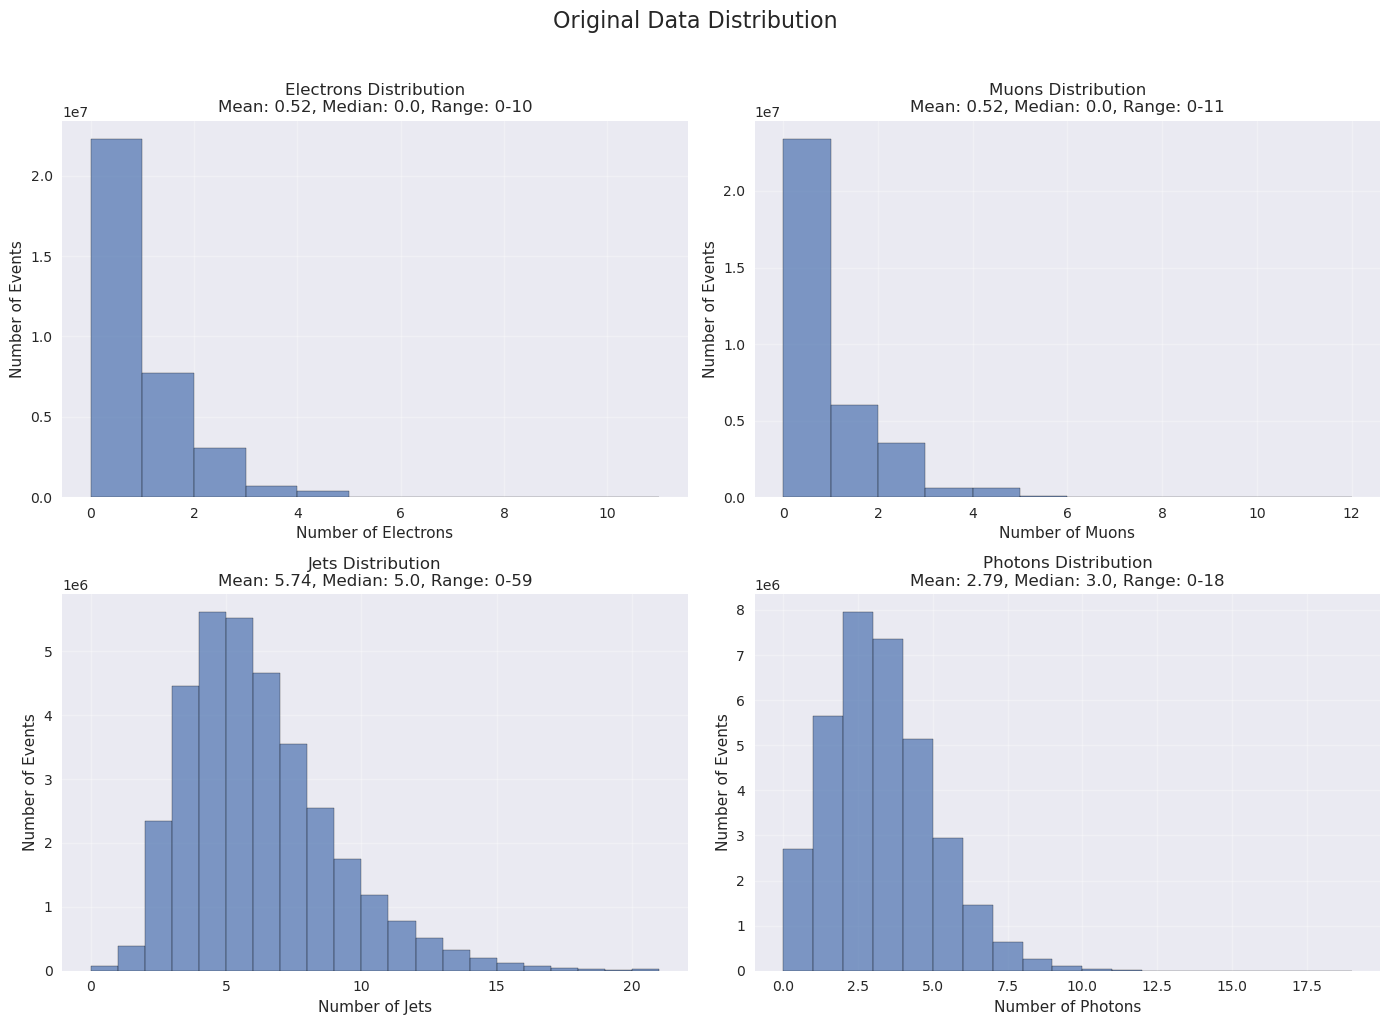

In [4]:
def analyze_particle_counts(events, title="Particle Counts"):
    """Analyze and visualize particle count distributions"""
    particle_types = ['Electrons', 'Muons', 'Jets', 'Photons']
    
    # Find actual field names
    actual_fields = {}
    for ptype in particle_types:
        for field in events.fields:
            if ptype.lower() in field.lower():
                actual_fields[ptype] = field
                break
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    stats = {}
    
    for idx, ptype in enumerate(particle_types):
        if ptype not in actual_fields:
            axes[idx].text(0.5, 0.5, f"{ptype} not found", 
                         ha='center', va='center', fontsize=14)
            axes[idx].set_title(f"{ptype} Distribution")
            stats[ptype] = {'mean': 0, 'median': 0, 'min': 0, 'max': 0}
            continue
        
        field = actual_fields[ptype]
        counts = ak.num(events[field])
        
        # Convert to numpy for easier analysis
        counts_np = ak.to_numpy(counts)
        
        # Statistics
        stats[ptype] = {
            'mean': float(np.mean(counts_np)),
            'median': float(np.median(counts_np)),
            'min': int(np.min(counts_np)),
            'max': int(np.max(counts_np)),
            'std': float(np.std(counts_np))
        }
        
        # Plot histogram
        max_count = min(int(np.max(counts_np)), 20)  # Cap at 20 for readability
        bins = range(0, max_count + 2)
        axes[idx].hist(counts_np, bins=bins, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(f'Number of {ptype}')
        axes[idx].set_ylabel('Number of Events')
        axes[idx].set_title(f"{ptype} Distribution\n"
                           f"Mean: {stats[ptype]['mean']:.2f}, "
                           f"Median: {stats[ptype]['median']:.1f}, "
                           f"Range: {stats[ptype]['min']}-{stats[ptype]['max']}")
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return stats, actual_fields

# Analyze original data
if events_chunk is not None:
    original_stats, field_mapping = analyze_particle_counts(events_chunk, "Original Data Distribution")


## Step-by-Step Filtering Analysis


In [5]:
def count_events_passing_particle_filters(events, particle_counts_config, field_mapping):
    """Count how many events pass each particle count filter"""
    results = {}
    
    # Start with all events
    combined_mask = ak.ones_like(ak.num(events[events.fields[0]]), dtype=bool)
    
    for particle_type, count_range in particle_counts_config.items():
        if particle_type not in field_mapping:
            results[particle_type] = {
                'total_events': len(events),
                'passing_events': 0,
                'passing_percent': 0.0,
                'reason': 'Field not found'
            }
            continue
        
        field = field_mapping[particle_type]
        obj_array = events[field]
        
        if ak.all(ak.is_none(obj_array)):
            results[particle_type] = {
                'total_events': len(events),
                'passing_events': 0,
                'passing_percent': 0.0,
                'reason': 'All None'
            }
            continue
        
        obj_count = ak.num(obj_array)
        particle_mask = (obj_count >= count_range['min']) & (obj_count <= count_range['max'])
        
        passing = int(ak.sum(particle_mask))
        total = len(events)
        
        results[particle_type] = {
            'total_events': total,
            'passing_events': passing,
            'passing_percent': (passing / total * 100) if total > 0 else 0.0,
            'min_required': count_range['min'],
            'max_allowed': count_range['max'],
            'actual_min': int(ak.min(obj_count)),
            'actual_max': int(ak.max(obj_count)),
            'actual_mean': float(ak.mean(obj_count))
        }
        
        # Update combined mask
        combined_mask = combined_mask & particle_mask
    
    # Count events passing ALL filters
    all_passing = int(ak.sum(combined_mask))
    results['ALL_FILTERS_COMBINED'] = {
        'total_events': len(events),
        'passing_events': all_passing,
        'passing_percent': (all_passing / len(events) * 100) if len(events) > 0 else 0.0
    }
    
    return results

# Analyze filtering step by step
if events_chunk is not None:
    print("\n" + "="*80)
    print("PARTICLE COUNT FILTER ANALYSIS")
    print("="*80)
    
    filter_results = count_events_passing_particle_filters(
        events_chunk, particle_counts, field_mapping
    )
    
    # Create a summary table
    summary_data = []
    for particle_type, result in filter_results.items():
        if particle_type == 'ALL_FILTERS_COMBINED':
            continue
        summary_data.append({
            'Particle Type': particle_type,
            'Total Events': result['total_events'],
            'Passing Events': result['passing_events'],
            'Passing %': f"{result['passing_percent']:.2f}%",
            'Required Range': f"{result.get('min_required', 'N/A')}-{result.get('max_allowed', 'N/A')}",
            'Actual Range': f"{result.get('actual_min', 'N/A')}-{result.get('actual_max', 'N/A')}",
            'Actual Mean': f"{result.get('actual_mean', 'N/A'):.2f}"
        })
    
    df = pd.DataFrame(summary_data)
    print("\n" + df.to_string(index=False))
    
    print("\n" + "-"*80)
    print(f"COMBINED FILTER RESULT:")
    combined = filter_results['ALL_FILTERS_COMBINED']
    print(f"  Total Events: {combined['total_events']:,}")
    print(f"  Passing Events: {combined['passing_events']:,}")
    print(f"  Passing Percentage: {combined['passing_percent']:.2f}%")
    print(f"  Filtered Out: {combined['total_events'] - combined['passing_events']:,} "
          f"({100 - combined['passing_percent']:.2f}%)")



PARTICLE COUNT FILTER ANALYSIS

Particle Type  Total Events  Passing Events Passing % Required Range Actual Range Actual Mean
    Electrons      34221400        11916519    34.82%            1-6         0-10        0.52
        Muons      34221400        10802999    31.57%            1-6         0-11        0.52
         Jets      34221400        28679805    83.81%            2-8         0-59        5.74
      Photons      34221400        31721028    92.69%            0-5         0-18        2.79

--------------------------------------------------------------------------------
COMBINED FILTER RESULT:
  Total Events: 34,221,400
  Passing Events: 3,730,083
  Passing Percentage: 10.90%
  Filtered Out: 30,491,317 (89.10%)


## Visualize Filter Impact


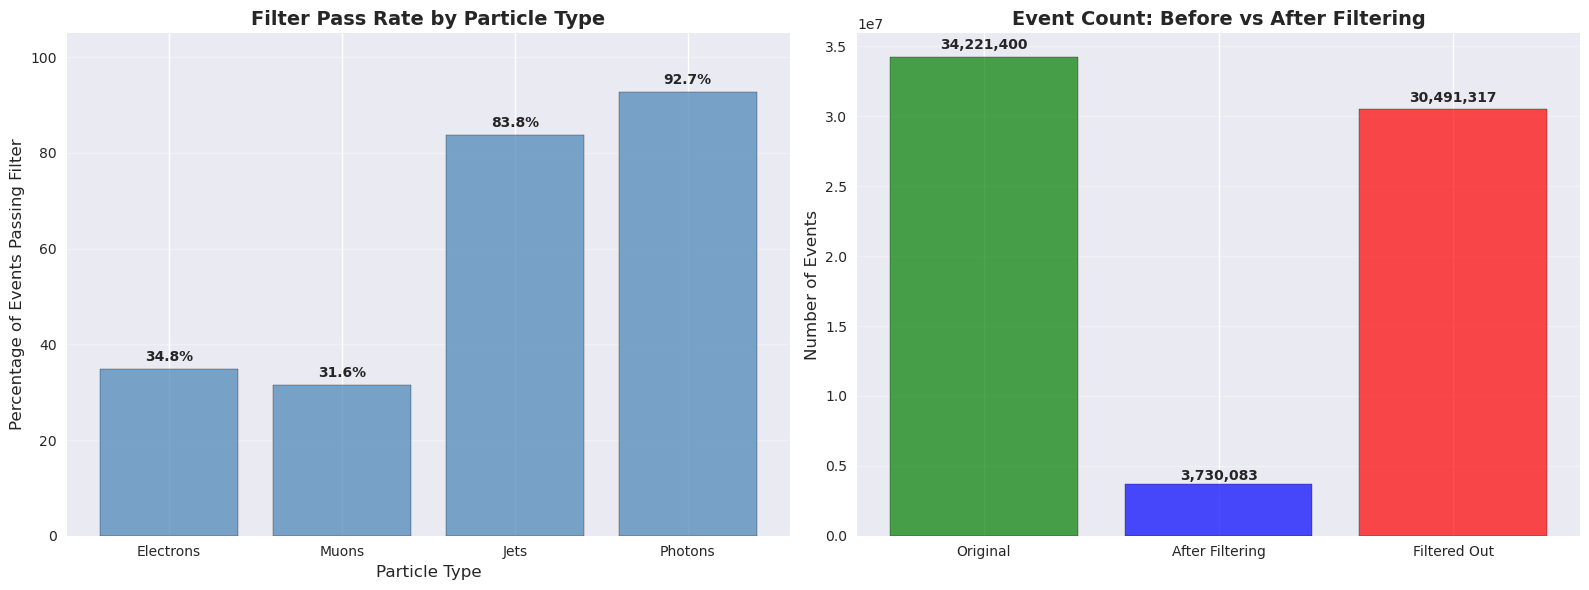


FILTERING SUMMARY
Original Events: 34,221,400
Events Passing Filters: 3,730,083 (10.90%)
Events Filtered Out: 30,491,317 (89.10%)


In [6]:
# Visualize the filtering impact
if events_chunk is not None and 'filter_results' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Passing percentage per filter
    particle_types = [k for k in filter_results.keys() if k != 'ALL_FILTERS_COMBINED']
    passing_pcts = [filter_results[pt]['passing_percent'] for pt in particle_types]
    
    bars = ax1.bar(particle_types, passing_pcts, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Percentage of Events Passing Filter', fontsize=12)
    ax1.set_xlabel('Particle Type', fontsize=12)
    ax1.set_title('Filter Pass Rate by Particle Type', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 105])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, pct in zip(bars, passing_pcts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Events before and after filtering
    total_events = len(events_chunk)
    passing_events = filter_results['ALL_FILTERS_COMBINED']['passing_events']
    filtered_events = total_events - passing_events
    
    categories = ['Original', 'After Filtering', 'Filtered Out']
    values = [total_events, passing_events, filtered_events]
    colors = ['green', 'blue', 'red']
    
    bars2 = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Events', fontsize=12)
    ax2.set_title('Event Count: Before vs After Filtering', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars2, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{val:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"FILTERING SUMMARY")
    print(f"{'='*80}")
    print(f"Original Events: {total_events:,}")
    print(f"Events Passing Filters: {passing_events:,} ({passing_events/total_events*100:.2f}%)")
    print(f"Events Filtered Out: {filtered_events:,} ({filtered_events/total_events*100:.2f}%)")


## Apply Actual Filters and Compare


In [7]:
# Apply the actual filtering pipeline
if events_chunk is not None:
    print("Applying kinematic cuts...")
    original_size_mb = events_chunk.layout.nbytes / (1024**2)
    original_events = len(events_chunk)
    
    # Step 1: Kinematic filtering
    cut_events = physics_calcs.filter_events_by_kinematics(
        events_chunk, kinematic_cuts
    )
    
    cut_size_mb = cut_events.layout.nbytes / (1024**2)
    cut_events_count = len(cut_events)
    
    print(f"  After kinematic cuts: {cut_events_count:,} events ({cut_size_mb:.2f} MB)")
    print(f"  Removed: {original_events - cut_events_count:,} events "
          f"({(1 - cut_events_count/original_events)*100:.2f}%)")
    
    # Step 2: Particle count filtering
    print("\nApplying particle count filters...")
    filtered_events = physics_calcs.filter_events_by_particle_counts(
        events=cut_events,
        particle_counts=particle_counts,
        is_particle_counts_range=True
    )
    
    filtered_size_mb = filtered_events.layout.nbytes / (1024**2)
    filtered_events_count = len(filtered_events)
    
    print(f"  After particle count filters: {filtered_events_count:,} events ({filtered_size_mb:.2f} MB)")
    print(f"  Removed: {cut_events_count - filtered_events_count:,} events "
          f"({(1 - filtered_events_count/cut_events_count)*100:.2f}%)")
    
    # Overall summary
    print(f"\n{'='*80}")
    print(f"OVERALL FILTERING SUMMARY")
    print(f"{'='*80}")
    print(f"Original: {original_events:,} events, {original_size_mb:.2f} MB")
    print(f"After Kinematic Cuts: {cut_events_count:,} events, {cut_size_mb:.2f} MB")
    print(f"After Particle Count Filters: {filtered_events_count:,} events, {filtered_size_mb:.2f} MB")
    print(f"\nTotal Reduction: ")
    print(f"  Events: {original_events - filtered_events_count:,} "
          f"({(1 - filtered_events_count/original_events)*100:.2f}% removed)")
    print(f"  Size: {original_size_mb - filtered_size_mb:.2f} MB "
          f"({(1 - filtered_size_mb/original_size_mb)*100:.2f}% removed)")


Applying kinematic cuts...


  After kinematic cuts: 34,221,400 events (5103.83 MB)
  Removed: 0 events (0.00%)

Applying particle count filters...
  After particle count filters: 3,730,083 events (832.59 MB)
  Removed: 30,491,317 events (89.10%)

OVERALL FILTERING SUMMARY
Original: 34,221,400 events, 4791.56 MB
After Kinematic Cuts: 34,221,400 events, 5103.83 MB
After Particle Count Filters: 3,730,083 events, 832.59 MB

Total Reduction: 
  Events: 30,491,317 (89.10% removed)
  Size: 3958.97 MB (82.62% removed)


## Analyze Why Events Are Being Filtered


In [8]:
# Detailed analysis of why events fail filters
if events_chunk is not None:
    print("\n" + "="*80)
    print("DETAILED FILTER FAILURE ANALYSIS")
    print("="*80)
    
    # For each particle type, show distribution of counts
    failure_reasons = defaultdict(int)
    
    for particle_type, count_range in particle_counts.items():
        if particle_type not in field_mapping:
            continue
        
        field = field_mapping[particle_type]
        obj_array = events_chunk[field]
        
        if ak.all(ak.is_none(obj_array)):
            continue
        
        obj_count = ak.num(obj_array)
        obj_count_np = ak.to_numpy(obj_count)
        
        # Count failures
        too_few = np.sum(obj_count_np < count_range['min'])
        too_many = np.sum(obj_count_np > count_range['max'])
        in_range = np.sum((obj_count_np >= count_range['min']) & (obj_count_np <= count_range['max']))
        
        print(f"\n{particle_type}:")
        print(f"  Required range: {count_range['min']} - {count_range['max']}")
        print(f"  Events with too few (< {count_range['min']}): {too_few:,} ({too_few/len(events_chunk)*100:.2f}%)")
        print(f"  Events with too many (> {count_range['max']}): {too_many:,} ({too_many/len(events_chunk)*100:.2f}%)")
        print(f"  Events in range: {in_range:,} ({in_range/len(events_chunk)*100:.2f}%)")
        
        # Show distribution
        unique_counts, counts = np.unique(obj_count_np, return_counts=True)
        print(f"  Distribution:")
        for uc, c in zip(unique_counts[:15], counts[:15]):  # Show first 15
            marker = "✓" if count_range['min'] <= uc <= count_range['max'] else "✗"
            print(f"    {marker} {uc:2d} particles: {c:6,} events ({c/len(events_chunk)*100:5.2f}%)")



DETAILED FILTER FAILURE ANALYSIS

Electrons:
  Required range: 1 - 6
  Events with too few (< 1): 22,303,886 (65.18%)
  Events with too many (> 6): 995 (0.00%)
  Events in range: 11,916,519 (34.82%)
  Distribution:
    ✗  0 particles: 22,303,886 events (65.18%)
    ✓  1 particles: 7,719,294 events (22.56%)
    ✓  2 particles: 3,061,921 events ( 8.95%)
    ✓  3 particles: 715,948 events ( 2.09%)
    ✓  4 particles: 368,694 events ( 1.08%)
    ✓  5 particles: 44,586 events ( 0.13%)
    ✓  6 particles:  6,076 events ( 0.02%)
    ✗  7 particles:    829 events ( 0.00%)
    ✗  8 particles:    142 events ( 0.00%)
    ✗  9 particles:     20 events ( 0.00%)
    ✗ 10 particles:      4 events ( 0.00%)

Muons:
  Required range: 1 - 6
  Events with too few (< 1): 23,416,774 (68.43%)
  Events with too many (> 6): 1,627 (0.00%)
  Events in range: 10,802,999 (31.57%)
  Distribution:
    ✗  0 particles: 23,416,774 events (68.43%)
    ✓  1 particles: 6,007,599 events (17.56%)
    ✓  2 particles: 3,532,

## Recommendations


In [9]:
# Generate recommendations based on the analysis
if events_chunk is not None and 'filter_results' in locals():
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    for particle_type, result in filter_results.items():
        if particle_type == 'ALL_FILTERS_COMBINED':
            continue
        
        passing_pct = result['passing_percent']
        actual_mean = result.get('actual_mean', 0)
        min_req = result.get('min_required', 0)
        max_allowed = result.get('max_allowed', 0)
        
        if passing_pct < 10:
            recommendations.append(
                f"⚠️  {particle_type}: Only {passing_pct:.1f}% of events pass. "
                f"Consider adjusting range from [{min_req}-{max_allowed}] "
                f"(actual mean: {actual_mean:.2f})"
            )
        elif passing_pct < 50:
            recommendations.append(
                f"⚠️  {particle_type}: {passing_pct:.1f}% pass. "
                f"Current range [{min_req}-{max_allowed}] may be too restrictive."
            )
        else:
            recommendations.append(
                f"✓ {particle_type}: {passing_pct:.1f}% pass. Filter seems reasonable."
            )
    
    combined_pct = filter_results['ALL_FILTERS_COMBINED']['passing_percent']
    
    print("\nFilter Analysis:")
    for rec in recommendations:
        print(f"  {rec}")
    
    print(f"\nOverall: {combined_pct:.2f}% of events pass all filters.")
    
    if combined_pct < 5:
        print("\n🔴 WARNING: Very few events pass all filters!")
        print("   This suggests the filter criteria may be too restrictive.")
        print("   Consider:")
        print("   1. Widening the particle count ranges")
        print("   2. Checking if the requirements are realistic for your data")
        print("   3. Verifying that all required particle types are present in the data")
    elif combined_pct < 20:
        print("\n🟡 CAUTION: Less than 20% of events pass filters.")
        print("   This may be intentional, but verify the filter criteria are appropriate.")
    else:
        print("\n✓ Filtering rate seems reasonable.")



RECOMMENDATIONS

Filter Analysis:
  ⚠️  Electrons: 34.8% pass. Current range [1-6] may be too restrictive.
  ⚠️  Muons: 31.6% pass. Current range [1-6] may be too restrictive.
  ✓ Jets: 83.8% pass. Filter seems reasonable.
  ✓ Photons: 92.7% pass. Filter seems reasonable.

Overall: 10.90% of events pass all filters.

🟡 CAUTION: Less than 20% of events pass filters.
   This may be intentional, but verify the filter criteria are appropriate.


## Compare Filtered vs Original Distributions


Analyzing filtered data distribution...


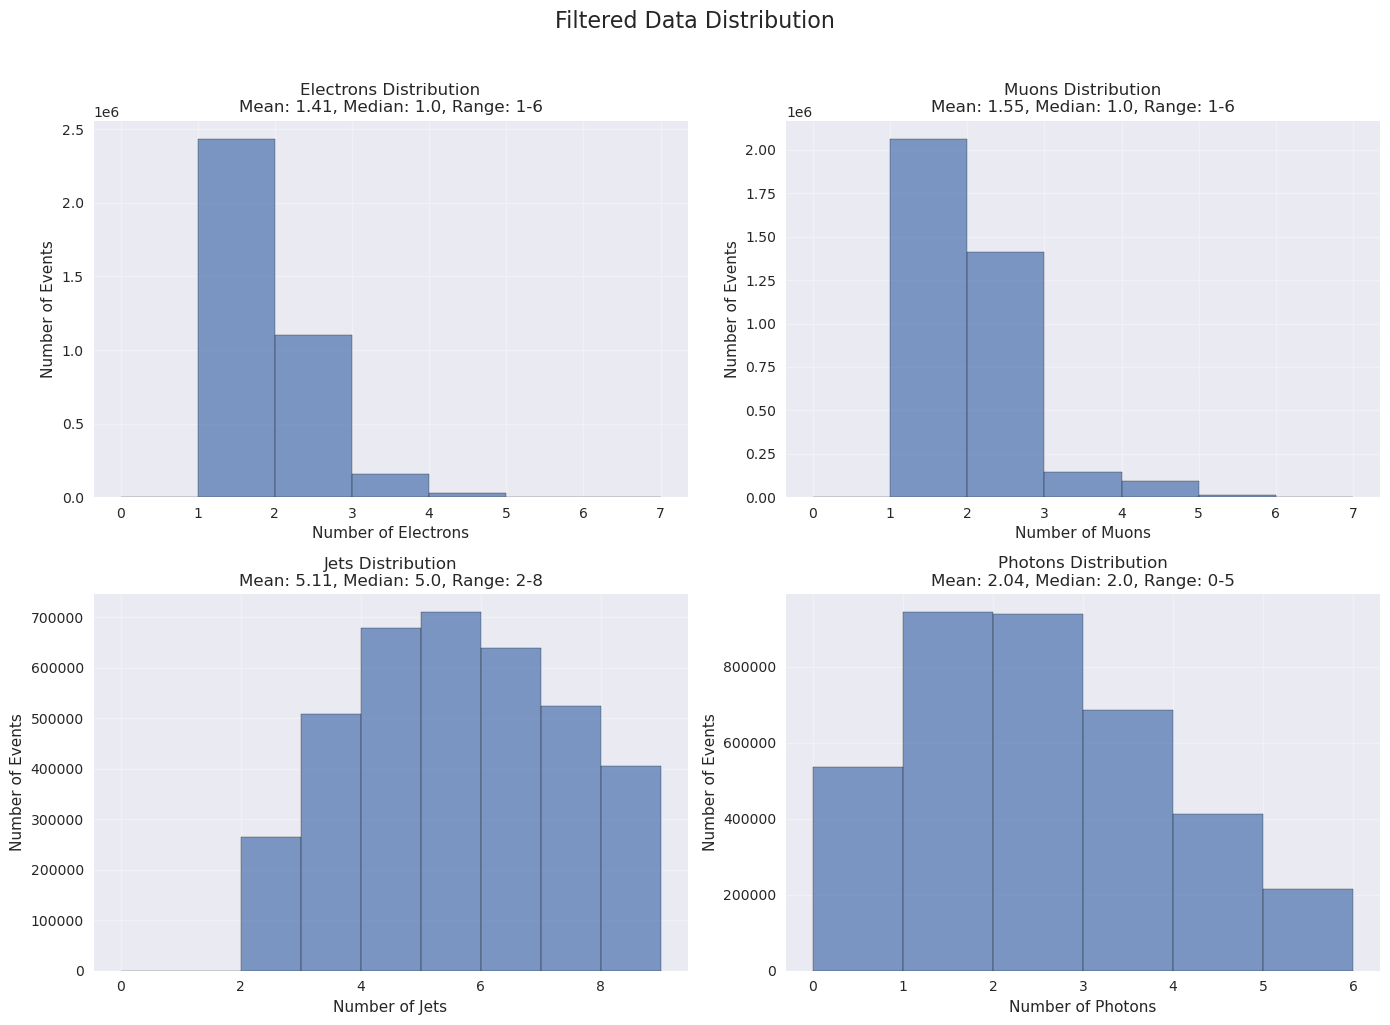


COMPARISON: Original vs Filtered

 Particle Original Mean Filtered Mean Original Range Filtered Range
Electrons          0.52          1.41           0-10            1-6
    Muons          0.52          1.55           0-11            1-6
     Jets          5.74          5.11           0-59            2-8
  Photons          2.79          2.04           0-18            0-5


In [10]:
# Compare distributions before and after filtering
if events_chunk is not None and 'filtered_events' in locals():
    print("Analyzing filtered data distribution...")
    filtered_stats, _ = analyze_particle_counts(filtered_events, "Filtered Data Distribution")
    
    # Compare statistics
    print("\n" + "="*80)
    print("COMPARISON: Original vs Filtered")
    print("="*80)
    
    comparison_data = []
    for particle_type in ['Electrons', 'Muons', 'Jets', 'Photons']:
        if particle_type in original_stats and particle_type in filtered_stats:
            orig = original_stats[particle_type]
            filt = filtered_stats[particle_type]
            comparison_data.append({
                'Particle': particle_type,
                'Original Mean': f"{orig['mean']:.2f}",
                'Filtered Mean': f"{filt['mean']:.2f}",
                'Original Range': f"{orig['min']}-{orig['max']}",
                'Filtered Range': f"{filt['min']}-{filt['max']}",
            })
    
    if comparison_data:
        df_comp = pd.DataFrame(comparison_data)
        print("\n" + df_comp.to_string(index=False))
